## Generating Benchmark Data for M5

The data is taken from the [M5 Forecasting - Accuracy](https://www.kaggle.com/c/m5-forecasting-accuracy) challenge on Kaggle, a competiton organized by The Makridakis Open Forecasting Center (MOFC) at the University of Nicosia ($50,000).

In [35]:
ROOT = "/data/cmu/large-scale-hts-reconciliation/"
data_dir = ROOT + "notebooks/"
TIME_HORIZON = 100

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from tqdm import tqdm
import pickle

### ETL (Extract, Transform & Load) from Kaggle

In [37]:
SMALL = True
df = pd.read_csv(data_dir + 'sales_train_evaluation.csv').fillna(0)
if SMALL: df = df.loc[df['cat_id'] == 'HOBBIES']
import collections
collections.Counter(df['dept_id'].values), \
collections.Counter(df['cat_id'].values), \
collections.Counter(df['store_id'].values), \
collections.Counter(df['state_id'].values)

(Counter({'HOBBIES_1': 4160, 'HOBBIES_2': 1490}),
 Counter({'HOBBIES': 5650}),
 Counter({'CA_1': 565,
          'CA_2': 565,
          'CA_3': 565,
          'CA_4': 565,
          'TX_1': 565,
          'TX_2': 565,
          'TX_3': 565,
          'WI_1': 565,
          'WI_2': 565,
          'WI_3': 565}),
 Counter({'CA': 2260, 'TX': 1695, 'WI': 1695}))

In [38]:
df

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28001,HOBBIES_2_145_WI_3_evaluation,HOBBIES_2_145,HOBBIES_2,HOBBIES,WI_3,WI,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
28002,HOBBIES_2_146_WI_3_evaluation,HOBBIES_2_146,HOBBIES_2,HOBBIES,WI_3,WI,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
28003,HOBBIES_2_147_WI_3_evaluation,HOBBIES_2_147,HOBBIES_2,HOBBIES,WI_3,WI,0,0,0,0,...,0,2,0,0,0,1,2,0,0,0
28004,HOBBIES_2_148_WI_3_evaluation,HOBBIES_2_148,HOBBIES_2,HOBBIES,WI_3,WI,0,0,0,1,...,0,0,0,0,1,2,0,0,1,0


### Compiling the hierarchies

In [39]:
try:
    df.drop(columns = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], inplace=True)
except:
    _  = 1

df['Cat/Dept/Item/State'] = df['id'].apply(lambda x: '_'.join(x.split('_')[:-1]))
df['Cat/Dept/Item'] = df['id'].apply(lambda x: '_'.join(x.split('_')[:-3]))
df['Cat/Dept'] = df['id'].apply(lambda x: '_'.join(x.split('_')[:-4]))
df['Cat'] = df['id'].apply(lambda x: x.split('_')[-6])

In [40]:
start = pd.to_datetime("2016-01-01")
ds = [start + pd.Timedelta(days = int(x[2:])) for x in (df.columns)[1:-4]]
ds = ['unique_id'] + ds + ['Cat/Dept/Item/State', 'Cat/Dept/Item', 'Cat/Dept', 'Cat']

In [41]:
df.columns = ds
df['unique_id'] = df['Cat/Dept/Item/State']

In [42]:
df

,unique_id,2016-01-02 00:00:00,2016-01-03 00:00:00,2016-01-04 00:00:00,2016-01-05 00:00:00,2016-01-06 00:00:00,2016-01-07 00:00:00,2016-01-08 00:00:00,2016-01-09 00:00:00,2016-01-10 00:00:00,...,2021-04-20 00:00:00,2021-04-21 00:00:00,2021-04-22 00:00:00,2021-04-23 00:00:00,2021-04-24 00:00:00,2021-04-25 00:00:00,Cat/Dept/Item/State,Cat/Dept/Item,Cat/Dept,Cat
0,HOBBIES_1_001_CA_1,0,0,0,0,0,0,0,0,0,...,0,0,3,3,0,1,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES
1,HOBBIES_1_002_CA_1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES
2,HOBBIES_1_003_CA_1,0,0,0,0,0,0,0,0,0,...,0,0,2,3,0,1,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES
3,HOBBIES_1_004_CA_1,0,0,0,0,0,0,0,0,0,...,0,1,3,0,2,6,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES
4,HOBBIES_1_005_CA_1,0,0,0,0,0,0,0,0,0,...,1,0,0,2,1,0,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28001,HOBBIES_2_145_WI_3,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,HOBBIES_2_145_WI_3,HOBBIES_2_145,HOBBIES_2,HOBBIES
28002,HOBBIES_2_146_WI_3,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,HOBBIES_2_146_WI_3,HOBBIES_2_146,HOBBIES_2,HOBBIES
28003,HOBBIES_2_147_WI_3,0,0,0,0,0,0,0,0,0,...,0,1,2,0,0,0,HOBBIES_2_147_WI_3,HOBBIES_2_147,HOBBIES_2,HOBBIES
28004,HOBBIES_2_148_WI_3,0,0,0,1,0,0,0,1,0,...,1,2,0,0,1,0,HOBBIES_2_148_WI_3,HOBBIES_2_148,HOBBIES_2,HOBBIES


#### Roll-up to produce parent forecasts

In [43]:
tags = {}
tags['Cat'] = df['Cat'].unique()
tags['Cat/Dept'] = df['Cat/Dept'].unique()
tags['Cat/Dept/Item'] = df['Cat/Dept/Item'].unique()
tags['Cat/Dept/Item/State'] = df['Cat/Dept/Item/State'].unique()

In [44]:
tags

{'Cat': array(['HOBBIES'], dtype=object),
 'Cat/Dept': array(['HOBBIES_1', 'HOBBIES_2'], dtype=object),
 'Cat/Dept/Item': array(['HOBBIES_1_001', 'HOBBIES_1_002', 'HOBBIES_1_003', 'HOBBIES_1_004',
        'HOBBIES_1_005', 'HOBBIES_1_006', 'HOBBIES_1_007', 'HOBBIES_1_008',
        'HOBBIES_1_009', 'HOBBIES_1_010', 'HOBBIES_1_011', 'HOBBIES_1_012',
        'HOBBIES_1_013', 'HOBBIES_1_014', 'HOBBIES_1_015', 'HOBBIES_1_016',
        'HOBBIES_1_017', 'HOBBIES_1_018', 'HOBBIES_1_019', 'HOBBIES_1_020',
        'HOBBIES_1_021', 'HOBBIES_1_022', 'HOBBIES_1_023', 'HOBBIES_1_024',
        'HOBBIES_1_025', 'HOBBIES_1_026', 'HOBBIES_1_027', 'HOBBIES_1_028',
        'HOBBIES_1_029', 'HOBBIES_1_030', 'HOBBIES_1_031', 'HOBBIES_1_032',
        'HOBBIES_1_033', 'HOBBIES_1_034', 'HOBBIES_1_035', 'HOBBIES_1_036',
        'HOBBIES_1_037', 'HOBBIES_1_038', 'HOBBIES_1_039', 'HOBBIES_1_040',
        'HOBBIES_1_041', 'HOBBIES_1_042', 'HOBBIES_1_043', 'HOBBIES_1_044',
        'HOBBIES_1_045', 'HOBBIES_1_046', '

In [45]:
node_map = {}
node_map_inv = {}

i = 0

for l in ['Cat/Dept/Item/State', 'Cat/Dept/Item', 'Cat/Dept', 'Cat']:
    for c in tags[l]:
        node_map[i] = c
        node_map_inv[c] = i
        i += 1

total_bottom = len(tags['Cat/Dept/Item/State'])
total_parent = len(tags['Cat/Dept/Item']) + len(tags['Cat/Dept']) + len(tags['Cat'])
parents = list(tags['Cat/Dept/Item']) + list(tags['Cat/Dept']) + list(tags['Cat'])
time_index = (df.columns)[1:-4]

In [46]:
pickle.dump([node_map_inv, node_map], open(data_dir + 'm5_node_map.pkl', 'wb'))

In [47]:
df

,unique_id,2016-01-02 00:00:00,2016-01-03 00:00:00,2016-01-04 00:00:00,2016-01-05 00:00:00,2016-01-06 00:00:00,2016-01-07 00:00:00,2016-01-08 00:00:00,2016-01-09 00:00:00,2016-01-10 00:00:00,...,2021-04-20 00:00:00,2021-04-21 00:00:00,2021-04-22 00:00:00,2021-04-23 00:00:00,2021-04-24 00:00:00,2021-04-25 00:00:00,Cat/Dept/Item/State,Cat/Dept/Item,Cat/Dept,Cat
0,HOBBIES_1_001_CA_1,0,0,0,0,0,0,0,0,0,...,0,0,3,3,0,1,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES
1,HOBBIES_1_002_CA_1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES
2,HOBBIES_1_003_CA_1,0,0,0,0,0,0,0,0,0,...,0,0,2,3,0,1,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES
3,HOBBIES_1_004_CA_1,0,0,0,0,0,0,0,0,0,...,0,1,3,0,2,6,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES
4,HOBBIES_1_005_CA_1,0,0,0,0,0,0,0,0,0,...,1,0,0,2,1,0,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28001,HOBBIES_2_145_WI_3,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,HOBBIES_2_145_WI_3,HOBBIES_2_145,HOBBIES_2,HOBBIES
28002,HOBBIES_2_146_WI_3,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,HOBBIES_2_146_WI_3,HOBBIES_2_146,HOBBIES_2,HOBBIES
28003,HOBBIES_2_147_WI_3,0,0,0,0,0,0,0,0,0,...,0,1,2,0,0,0,HOBBIES_2_147_WI_3,HOBBIES_2_147,HOBBIES_2,HOBBIES
28004,HOBBIES_2_148_WI_3,0,0,0,1,0,0,0,1,0,...,1,2,0,0,1,0,HOBBIES_2_148_WI_3,HOBBIES_2_148,HOBBIES_2,HOBBIES


In [48]:
parent_historical = np.zeros((total_parent, len(time_index))).astype(np.int64)

for _, ro in tqdm(df.iterrows()):
    vals = ro[time_index].values.astype(np.int64)
    parent_historical[node_map_inv[ro['Cat/Dept/Item']] - total_bottom, :] += vals
    parent_historical[node_map_inv[ro['Cat/Dept']] - total_bottom, :] += vals
    parent_historical[node_map_inv[ro['Cat']] - total_bottom, :] += vals

5650it [00:11, 480.36it/s]


In [49]:
parent_df = pd.DataFrame(data = parent_historical)
parent_df.columns = time_index

In [50]:
parent_df['unique_id'] = parents

In [51]:
parent_df['Cat/Dept/Item/State'] = np.nan

In [52]:
def p0(x):
    l = x.split('_')
    if len(l) < 3: return np.nan
    return x

def p1(x):
    l = x.split('_')
    if len(l) < 2: return np.nan
    return '_'.join(l[:2])

def p2(x):
    l = x.split('_')
    #if len(l) < 1: return np.nan
    return '_'.join(l[:1])

parent_df['Cat/Dept/Item'] = parent_df['unique_id'].apply(p0)
parent_df['Cat/Dept'] = parent_df['unique_id'].apply(p1)
parent_df['Cat'] = parent_df['unique_id'].apply(p2)
parent_df

,2016-01-02 00:00:00,2016-01-03 00:00:00,2016-01-04 00:00:00,2016-01-05 00:00:00,2016-01-06 00:00:00,2016-01-07 00:00:00,2016-01-08 00:00:00,2016-01-09 00:00:00,2016-01-10 00:00:00,2016-01-11 00:00:00,...,2021-04-21 00:00:00,2021-04-22 00:00:00,2021-04-23 00:00:00,2021-04-24 00:00:00,2021-04-25 00:00:00,unique_id,Cat/Dept/Item/State,Cat/Dept/Item,Cat/Dept,Cat
0,0,0,0,0,0,0,0,0,0,0,...,10,7,8,6,9,HOBBIES_1_001,NaN,HOBBIES_1_001,HOBBIES_1,HOBBIES
1,0,0,0,0,0,0,0,0,0,0,...,1,3,3,3,5,HOBBIES_1_002,NaN,HOBBIES_1_002,HOBBIES_1,HOBBIES
2,0,0,0,0,0,0,0,0,0,0,...,4,2,5,3,3,HOBBIES_1_003,NaN,HOBBIES_1_003,HOBBIES_1,HOBBIES
3,15,17,7,17,7,11,17,17,23,16,...,8,8,7,15,24,HOBBIES_1_004,NaN,HOBBIES_1_004,HOBBIES_1,HOBBIES
4,0,0,0,0,0,0,0,0,0,0,...,7,8,8,14,13,HOBBIES_1_005,NaN,HOBBIES_1_005,HOBBIES_1,HOBBIES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563,0,2,2,2,0,1,1,2,1,0,...,2,2,0,3,2,HOBBIES_2_148,NaN,HOBBIES_2_148,HOBBIES_2,HOBBIES
564,0,0,0,0,0,0,0,0,0,0,...,5,1,6,2,0,HOBBIES_2_149,NaN,HOBBIES_2_149,HOBBIES_2,HOBBIES
565,3610,3172,2497,2531,1714,3133,2855,3831,2741,2514,...,3291,3027,3761,4832,4720,HOBBIES_1,NaN,NaN,HOBBIES_1,HOBBIES
566,154,185,185,138,100,87,89,155,158,101,...,449,448,382,501,560,HOBBIES_2,NaN,NaN,HOBBIES_2,HOBBIES


In [53]:
total_df = pd.concat([df, parent_df])
total_df.to_csv(data_dir + 'm5_historical.csv', index=False)

#### Compute edge list for LHTS

In [54]:
edge_list = []
parent_list = []

for i, ro in tqdm(total_df.iterrows()):
    if type(ro['Cat/Dept/Item/State']) is str:
        edge_list.append([node_map_inv[ro['unique_id']], node_map_inv[ro['Cat/Dept/Item']]])
        parent_list.append([node_map_inv[ro['unique_id']], 
                            node_map_inv[ro['Cat/Dept/Item']],
                            node_map_inv[ro['Cat/Dept']],
                            node_map_inv[ro['Cat']],
                            ])
    elif type(ro['Cat/Dept/Item']) is str:
        edge_list.append([node_map_inv[ro['unique_id']], node_map_inv[ro['Cat/Dept']]])
        parent_list.append([node_map_inv[ro['unique_id']], 
                            node_map_inv[ro['Cat/Dept']],
                            node_map_inv[ro['Cat']],
                            -1
                            ])
    elif type(ro['Cat/Dept']) is str:
        edge_list.append([node_map_inv[ro['unique_id']], node_map_inv[ro['Cat']]])
        parent_list.append([node_map_inv[ro['unique_id']], 
                            node_map_inv[ro['Cat']],
                            -1,
                            -1
                            ])
    else:
        parent_list.append([node_map_inv[ro['unique_id']], 
                            -1, -1, -1])

6218it [00:00, 9344.58it/s] 


In [55]:
np.save(open(data_dir + 'm5_hierarchy.npy', 'wb'), np.array(edge_list))
np.save(open(data_dir + 'm5_prediction_raw/hierarchy.npy', 'wb'), np.array(edge_list))
np.save(open(data_dir + 'm5_hierarchy_parent.npy', 'wb'), np.array(parent_list))

In [56]:
np.array(parent_list).shape

(6218, 4)

### Produce forecast

In [57]:
FORECAST = True

if FORECAST:
    import dask.dataframe as dd

    ddf = dd.from_pandas(total_df, npartitions=4096)

    def predict(row):
        data = pd.DataFrame({'ds': (row.index)[1:-4][-TIME_HORIZON:], 'y':(row.values)[1:-4][-TIME_HORIZON:]})
        m = Prophet()
        m.fit(data)

        future = m.make_future_dataframe(periods=TIME_HORIZON)
        forecast = m.predict(future)

        return row.unique_id, forecast[['yhat']][-TIME_HORIZON:].values.reshape(-1)

    dask_series = ddf.apply(predict, axis=1, meta=('float', 'object'))  
    result = dask_series.compute(scheduler='processes')
    pickle.dump(result, open(data_dir + 'm5_prophet_forecast.pkl', 'wb'))

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
23:14:06 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
23:14:06 - cmdstanpy - INFO - Chain [1] done processing
23:14:06 - cmdsta

23:14:08 - cmdstanpy - INFO - Chain [1] done processing
23:14:08 - cmdstanpy - INFO - Chain [1] done processing
23:14:09 - cmdstanpy - INFO - Chain [1] start processing
23:14:09 - cmdstanpy - INFO - Chain [1] start processing
23:14:09 - cmdstanpy - INFO - Chain [1] start processing
23:14:09 - cmdstanpy - INFO - Chain [1] done processing
23:14:09 - cmdstanpy - INFO - Chain [1] start processing
23:14:09 - cmdstanpy - INFO - Chain [1] done processing
23:14:09 - cmdstanpy - INFO - Chain [1] done processing
23:14:09 - cmdstanpy - INFO - Chain [1] start processing
23:14:09 - cmdstanpy - INFO - Chain [1] done processing
23:14:09 - cmdstanpy - INFO - Chain [1] start processing
23:14:09 - cmdstanpy - INFO - Chain [1] start processing
23:14:09 - cmdstanpy - INFO - Chain [1] start processing
23:14:09 - cmdstanpy - INFO - Chain [1] done processing
23:14:09 - cmdstanpy - INFO - Chain [1] start processing
23:14:09 - cmdstanpy - INFO - Chain [1] done processing
23:14:09 - cmdstanpy - INFO - Chain [1]

23:14:11 - cmdstanpy - INFO - Chain [1] start processing
23:14:11 - cmdstanpy - INFO - Chain [1] start processing
23:14:11 - cmdstanpy - INFO - Chain [1] done processing
23:14:11 - cmdstanpy - INFO - Chain [1] done processing
23:14:11 - cmdstanpy - INFO - Chain [1] done processing
23:14:11 - cmdstanpy - INFO - Chain [1] done processing
23:14:11 - cmdstanpy - INFO - Chain [1] start processing
23:14:11 - cmdstanpy - INFO - Chain [1] done processing
23:14:11 - cmdstanpy - INFO - Chain [1] start processing
23:14:11 - cmdstanpy - INFO - Chain [1] start processing
23:14:11 - cmdstanpy - INFO - Chain [1] done processing
23:14:11 - cmdstanpy - INFO - Chain [1] start processing
23:14:11 - cmdstanpy - INFO - Chain [1] done processing
23:14:11 - cmdstanpy - INFO - Chain [1] start processing
23:14:11 - cmdstanpy - INFO - Chain [1] start processing
23:14:11 - cmdstanpy - INFO - Chain [1] done processing
23:14:11 - cmdstanpy - INFO - Chain [1] done processing
23:14:11 - cmdstanpy - INFO - Chain [1] 

23:14:14 - cmdstanpy - INFO - Chain [1] start processing
23:14:14 - cmdstanpy - INFO - Chain [1] start processing
23:14:14 - cmdstanpy - INFO - Chain [1] start processing
23:14:14 - cmdstanpy - INFO - Chain [1] done processing
23:14:14 - cmdstanpy - INFO - Chain [1] start processing
23:14:14 - cmdstanpy - INFO - Chain [1] done processing
23:14:14 - cmdstanpy - INFO - Chain [1] done processing
23:14:14 - cmdstanpy - INFO - Chain [1] start processing
23:14:14 - cmdstanpy - INFO - Chain [1] done processing
23:14:14 - cmdstanpy - INFO - Chain [1] start processing
23:14:14 - cmdstanpy - INFO - Chain [1] done processing
23:14:14 - cmdstanpy - INFO - Chain [1] done processing
23:14:14 - cmdstanpy - INFO - Chain [1] start processing
23:14:14 - cmdstanpy - INFO - Chain [1] start processing
23:14:14 - cmdstanpy - INFO - Chain [1] start processing
23:14:14 - cmdstanpy - INFO - Chain [1] done processing
23:14:14 - cmdstanpy - INFO - Chain [1] done processing
23:14:14 - cmdstanpy - INFO - Chain [1]

23:14:17 - cmdstanpy - INFO - Chain [1] done processing
23:14:17 - cmdstanpy - INFO - Chain [1] start processing
23:14:17 - cmdstanpy - INFO - Chain [1] start processing
23:14:17 - cmdstanpy - INFO - Chain [1] start processing
23:14:17 - cmdstanpy - INFO - Chain [1] done processing
23:14:17 - cmdstanpy - INFO - Chain [1] done processing
23:14:17 - cmdstanpy - INFO - Chain [1] done processing
23:14:17 - cmdstanpy - INFO - Chain [1] start processing
23:14:17 - cmdstanpy - INFO - Chain [1] start processing
23:14:17 - cmdstanpy - INFO - Chain [1] done processing
23:14:17 - cmdstanpy - INFO - Chain [1] done processing
23:14:17 - cmdstanpy - INFO - Chain [1] start processing
23:14:17 - cmdstanpy - INFO - Chain [1] start processing
23:14:17 - cmdstanpy - INFO - Chain [1] start processing
23:14:17 - cmdstanpy - INFO - Chain [1] done processing
23:14:17 - cmdstanpy - INFO - Chain [1] done processing
23:14:17 - cmdstanpy - INFO - Chain [1] done processing
23:14:17 - cmdstanpy - INFO - Chain [1] 

23:14:19 - cmdstanpy - INFO - Chain [1] start processing
23:14:19 - cmdstanpy - INFO - Chain [1] done processing
23:14:19 - cmdstanpy - INFO - Chain [1] start processing
23:14:20 - cmdstanpy - INFO - Chain [1] done processing
23:14:20 - cmdstanpy - INFO - Chain [1] done processing
23:14:20 - cmdstanpy - INFO - Chain [1] start processing
23:14:20 - cmdstanpy - INFO - Chain [1] start processing
23:14:20 - cmdstanpy - INFO - Chain [1] start processing
23:14:20 - cmdstanpy - INFO - Chain [1] done processing
23:14:20 - cmdstanpy - INFO - Chain [1] start processing
23:14:20 - cmdstanpy - INFO - Chain [1] done processing
23:14:20 - cmdstanpy - INFO - Chain [1] done processing
23:14:20 - cmdstanpy - INFO - Chain [1] start processing
23:14:20 - cmdstanpy - INFO - Chain [1] done processing
23:14:20 - cmdstanpy - INFO - Chain [1] start processing
23:14:20 - cmdstanpy - INFO - Chain [1] done processing
23:14:20 - cmdstanpy - INFO - Chain [1] done processing
23:14:20 - cmdstanpy - INFO - Chain [1] 

23:14:22 - cmdstanpy - INFO - Chain [1] done processing
23:14:22 - cmdstanpy - INFO - Chain [1] done processing
23:14:22 - cmdstanpy - INFO - Chain [1] start processing
23:14:22 - cmdstanpy - INFO - Chain [1] start processing
23:14:22 - cmdstanpy - INFO - Chain [1] done processing
23:14:22 - cmdstanpy - INFO - Chain [1] done processing
23:14:22 - cmdstanpy - INFO - Chain [1] start processing
23:14:22 - cmdstanpy - INFO - Chain [1] done processing
23:14:22 - cmdstanpy - INFO - Chain [1] start processing
23:14:22 - cmdstanpy - INFO - Chain [1] start processing
23:14:22 - cmdstanpy - INFO - Chain [1] done processing
23:14:23 - cmdstanpy - INFO - Chain [1] start processing
23:14:23 - cmdstanpy - INFO - Chain [1] start processing
23:14:23 - cmdstanpy - INFO - Chain [1] done processing
23:14:23 - cmdstanpy - INFO - Chain [1] start processing
23:14:23 - cmdstanpy - INFO - Chain [1] done processing
23:14:23 - cmdstanpy - INFO - Chain [1] done processing
23:14:23 - cmdstanpy - INFO - Chain [1] 

23:14:25 - cmdstanpy - INFO - Chain [1] done processing
23:14:25 - cmdstanpy - INFO - Chain [1] start processing
23:14:25 - cmdstanpy - INFO - Chain [1] start processing
23:14:25 - cmdstanpy - INFO - Chain [1] start processing
23:14:25 - cmdstanpy - INFO - Chain [1] done processing
23:14:25 - cmdstanpy - INFO - Chain [1] done processing
23:14:25 - cmdstanpy - INFO - Chain [1] done processing
23:14:25 - cmdstanpy - INFO - Chain [1] start processing
23:14:25 - cmdstanpy - INFO - Chain [1] start processing
23:14:25 - cmdstanpy - INFO - Chain [1] start processing
23:14:25 - cmdstanpy - INFO - Chain [1] done processing
23:14:25 - cmdstanpy - INFO - Chain [1] done processing
23:14:25 - cmdstanpy - INFO - Chain [1] done processing
23:14:25 - cmdstanpy - INFO - Chain [1] start processing
23:14:25 - cmdstanpy - INFO - Chain [1] start processing
23:14:25 - cmdstanpy - INFO - Chain [1] start processing
23:14:25 - cmdstanpy - INFO - Chain [1] done processing
23:14:25 - cmdstanpy - INFO - Chain [1]

23:14:28 - cmdstanpy - INFO - Chain [1] start processing
23:14:28 - cmdstanpy - INFO - Chain [1] start processing
23:14:28 - cmdstanpy - INFO - Chain [1] done processing
23:14:28 - cmdstanpy - INFO - Chain [1] start processing
23:14:28 - cmdstanpy - INFO - Chain [1] done processing
23:14:28 - cmdstanpy - INFO - Chain [1] done processing
23:14:28 - cmdstanpy - INFO - Chain [1] start processing
23:14:28 - cmdstanpy - INFO - Chain [1] done processing
23:14:28 - cmdstanpy - INFO - Chain [1] start processing
23:14:28 - cmdstanpy - INFO - Chain [1] done processing
23:14:28 - cmdstanpy - INFO - Chain [1] start processing
23:14:28 - cmdstanpy - INFO - Chain [1] done processing
23:14:28 - cmdstanpy - INFO - Chain [1] start processing
23:14:28 - cmdstanpy - INFO - Chain [1] done processing
23:14:28 - cmdstanpy - INFO - Chain [1] start processing
23:14:28 - cmdstanpy - INFO - Chain [1] start processing
23:14:28 - cmdstanpy - INFO - Chain [1] done processing
23:14:28 - cmdstanpy - INFO - Chain [1]

23:14:30 - cmdstanpy - INFO - Chain [1] start processing
23:14:30 - cmdstanpy - INFO - Chain [1] done processing
23:14:30 - cmdstanpy - INFO - Chain [1] start processing
23:14:31 - cmdstanpy - INFO - Chain [1] done processing
23:14:31 - cmdstanpy - INFO - Chain [1] done processing
23:14:31 - cmdstanpy - INFO - Chain [1] start processing
23:14:31 - cmdstanpy - INFO - Chain [1] start processing
23:14:31 - cmdstanpy - INFO - Chain [1] start processing
23:14:31 - cmdstanpy - INFO - Chain [1] done processing
23:14:31 - cmdstanpy - INFO - Chain [1] start processing
23:14:31 - cmdstanpy - INFO - Chain [1] done processing
23:14:31 - cmdstanpy - INFO - Chain [1] done processing
23:14:31 - cmdstanpy - INFO - Chain [1] start processing
23:14:31 - cmdstanpy - INFO - Chain [1] done processing
23:14:31 - cmdstanpy - INFO - Chain [1] start processing
23:14:31 - cmdstanpy - INFO - Chain [1] start processing
23:14:31 - cmdstanpy - INFO - Chain [1] done processing
23:14:31 - cmdstanpy - INFO - Chain [1]

23:14:33 - cmdstanpy - INFO - Chain [1] done processing
23:14:33 - cmdstanpy - INFO - Chain [1] done processing
23:14:33 - cmdstanpy - INFO - Chain [1] start processing
23:14:33 - cmdstanpy - INFO - Chain [1] start processing
23:14:33 - cmdstanpy - INFO - Chain [1] done processing
23:14:33 - cmdstanpy - INFO - Chain [1] done processing
23:14:33 - cmdstanpy - INFO - Chain [1] start processing
23:14:33 - cmdstanpy - INFO - Chain [1] done processing
23:14:33 - cmdstanpy - INFO - Chain [1] start processing
23:14:33 - cmdstanpy - INFO - Chain [1] done processing
23:14:33 - cmdstanpy - INFO - Chain [1] start processing
23:14:33 - cmdstanpy - INFO - Chain [1] start processing
23:14:33 - cmdstanpy - INFO - Chain [1] start processing
23:14:33 - cmdstanpy - INFO - Chain [1] done processing
23:14:33 - cmdstanpy - INFO - Chain [1] done processing
23:14:33 - cmdstanpy - INFO - Chain [1] start processing
23:14:33 - cmdstanpy - INFO - Chain [1] start processing
23:14:33 - cmdstanpy - INFO - Chain [1]

23:14:36 - cmdstanpy - INFO - Chain [1] done processing
23:14:36 - cmdstanpy - INFO - Chain [1] done processing
23:14:36 - cmdstanpy - INFO - Chain [1] start processing
23:14:36 - cmdstanpy - INFO - Chain [1] start processing
23:14:36 - cmdstanpy - INFO - Chain [1] start processing
23:14:36 - cmdstanpy - INFO - Chain [1] done processing
23:14:36 - cmdstanpy - INFO - Chain [1] done processing
23:14:36 - cmdstanpy - INFO - Chain [1] done processing
23:14:36 - cmdstanpy - INFO - Chain [1] start processing
23:14:36 - cmdstanpy - INFO - Chain [1] start processing
23:14:36 - cmdstanpy - INFO - Chain [1] done processing
23:14:36 - cmdstanpy - INFO - Chain [1] done processing
23:14:36 - cmdstanpy - INFO - Chain [1] start processing
23:14:36 - cmdstanpy - INFO - Chain [1] done processing
23:14:36 - cmdstanpy - INFO - Chain [1] start processing
23:14:36 - cmdstanpy - INFO - Chain [1] start processing
23:14:36 - cmdstanpy - INFO - Chain [1] start processing
23:14:36 - cmdstanpy - INFO - Chain [1]

23:14:39 - cmdstanpy - INFO - Chain [1] done processing
23:14:39 - cmdstanpy - INFO - Chain [1] done processing
23:14:39 - cmdstanpy - INFO - Chain [1] start processing
23:14:39 - cmdstanpy - INFO - Chain [1] start processing
23:14:39 - cmdstanpy - INFO - Chain [1] start processing
23:14:39 - cmdstanpy - INFO - Chain [1] done processing
23:14:39 - cmdstanpy - INFO - Chain [1] done processing
23:14:39 - cmdstanpy - INFO - Chain [1] done processing
23:14:39 - cmdstanpy - INFO - Chain [1] start processing
23:14:39 - cmdstanpy - INFO - Chain [1] start processing
23:14:39 - cmdstanpy - INFO - Chain [1] done processing
23:14:39 - cmdstanpy - INFO - Chain [1] done processing
23:14:39 - cmdstanpy - INFO - Chain [1] start processing
23:14:39 - cmdstanpy - INFO - Chain [1] start processing
23:14:39 - cmdstanpy - INFO - Chain [1] done processing
23:14:39 - cmdstanpy - INFO - Chain [1] done processing
23:14:39 - cmdstanpy - INFO - Chain [1] start processing
23:14:39 - cmdstanpy - INFO - Chain [1] 

23:14:41 - cmdstanpy - INFO - Chain [1] done processing
23:14:41 - cmdstanpy - INFO - Chain [1] done processing
23:14:42 - cmdstanpy - INFO - Chain [1] start processing
23:14:42 - cmdstanpy - INFO - Chain [1] done processing
23:14:42 - cmdstanpy - INFO - Chain [1] start processing
23:14:42 - cmdstanpy - INFO - Chain [1] start processing
23:14:42 - cmdstanpy - INFO - Chain [1] done processing
23:14:42 - cmdstanpy - INFO - Chain [1] done processing
23:14:42 - cmdstanpy - INFO - Chain [1] start processing
23:14:42 - cmdstanpy - INFO - Chain [1] start processing
23:14:42 - cmdstanpy - INFO - Chain [1] start processing
23:14:42 - cmdstanpy - INFO - Chain [1] done processing
23:14:42 - cmdstanpy - INFO - Chain [1] start processing
23:14:42 - cmdstanpy - INFO - Chain [1] done processing
23:14:42 - cmdstanpy - INFO - Chain [1] done processing
23:14:42 - cmdstanpy - INFO - Chain [1] done processing
23:14:42 - cmdstanpy - INFO - Chain [1] start processing
23:14:42 - cmdstanpy - INFO - Chain [1] 

23:14:44 - cmdstanpy - INFO - Chain [1] done processing
23:14:44 - cmdstanpy - INFO - Chain [1] done processing
23:14:44 - cmdstanpy - INFO - Chain [1] done processing
23:14:44 - cmdstanpy - INFO - Chain [1] start processing
23:14:44 - cmdstanpy - INFO - Chain [1] start processing
23:14:44 - cmdstanpy - INFO - Chain [1] done processing
23:14:44 - cmdstanpy - INFO - Chain [1] start processing
23:14:44 - cmdstanpy - INFO - Chain [1] done processing
23:14:44 - cmdstanpy - INFO - Chain [1] start processing
23:14:44 - cmdstanpy - INFO - Chain [1] done processing
23:14:44 - cmdstanpy - INFO - Chain [1] done processing
23:14:44 - cmdstanpy - INFO - Chain [1] start processing
23:14:44 - cmdstanpy - INFO - Chain [1] done processing
23:14:44 - cmdstanpy - INFO - Chain [1] start processing
23:14:44 - cmdstanpy - INFO - Chain [1] start processing
23:14:45 - cmdstanpy - INFO - Chain [1] done processing
23:14:45 - cmdstanpy - INFO - Chain [1] start processing
23:14:45 - cmdstanpy - INFO - Chain [1] 

23:14:47 - cmdstanpy - INFO - Chain [1] start processing
23:14:47 - cmdstanpy - INFO - Chain [1] done processing
23:14:47 - cmdstanpy - INFO - Chain [1] start processing
23:14:47 - cmdstanpy - INFO - Chain [1] start processing
23:14:47 - cmdstanpy - INFO - Chain [1] start processing
23:14:47 - cmdstanpy - INFO - Chain [1] start processing
23:14:47 - cmdstanpy - INFO - Chain [1] start processing
23:14:47 - cmdstanpy - INFO - Chain [1] done processing
23:14:47 - cmdstanpy - INFO - Chain [1] done processing
23:14:47 - cmdstanpy - INFO - Chain [1] done processing
23:14:47 - cmdstanpy - INFO - Chain [1] start processing
23:14:47 - cmdstanpy - INFO - Chain [1] done processing
23:14:47 - cmdstanpy - INFO - Chain [1] done processing
23:14:47 - cmdstanpy - INFO - Chain [1] start processing
23:14:47 - cmdstanpy - INFO - Chain [1] done processing
23:14:47 - cmdstanpy - INFO - Chain [1] start processing
23:14:47 - cmdstanpy - INFO - Chain [1] done processing
23:14:47 - cmdstanpy - INFO - Chain [1]

23:14:50 - cmdstanpy - INFO - Chain [1] start processing
23:14:50 - cmdstanpy - INFO - Chain [1] start processing
23:14:50 - cmdstanpy - INFO - Chain [1] done processing
23:14:50 - cmdstanpy - INFO - Chain [1] done processing
23:14:50 - cmdstanpy - INFO - Chain [1] start processing
23:14:50 - cmdstanpy - INFO - Chain [1] start processing
23:14:50 - cmdstanpy - INFO - Chain [1] start processing
23:14:50 - cmdstanpy - INFO - Chain [1] start processing
23:14:50 - cmdstanpy - INFO - Chain [1] start processing
23:14:50 - cmdstanpy - INFO - Chain [1] done processing
23:14:50 - cmdstanpy - INFO - Chain [1] start processing
23:14:50 - cmdstanpy - INFO - Chain [1] done processing
23:14:50 - cmdstanpy - INFO - Chain [1] done processing
23:14:50 - cmdstanpy - INFO - Chain [1] done processing
23:14:50 - cmdstanpy - INFO - Chain [1] done processing
23:14:50 - cmdstanpy - INFO - Chain [1] start processing
23:14:50 - cmdstanpy - INFO - Chain [1] start processing
23:14:50 - cmdstanpy - INFO - Chain [1

23:14:52 - cmdstanpy - INFO - Chain [1] start processing
23:14:52 - cmdstanpy - INFO - Chain [1] start processing
23:14:52 - cmdstanpy - INFO - Chain [1] start processing
23:14:52 - cmdstanpy - INFO - Chain [1] done processing
23:14:52 - cmdstanpy - INFO - Chain [1] start processing
23:14:52 - cmdstanpy - INFO - Chain [1] done processing
23:14:52 - cmdstanpy - INFO - Chain [1] done processing
23:14:52 - cmdstanpy - INFO - Chain [1] start processing
23:14:52 - cmdstanpy - INFO - Chain [1] start processing
23:14:52 - cmdstanpy - INFO - Chain [1] done processing
23:14:52 - cmdstanpy - INFO - Chain [1] done processing
23:14:52 - cmdstanpy - INFO - Chain [1] start processing
23:14:52 - cmdstanpy - INFO - Chain [1] start processing
23:14:52 - cmdstanpy - INFO - Chain [1] done processing
23:14:52 - cmdstanpy - INFO - Chain [1] done processing
23:14:52 - cmdstanpy - INFO - Chain [1] done processing
23:14:52 - cmdstanpy - INFO - Chain [1] start processing
23:14:52 - cmdstanpy - INFO - Chain [1]

23:14:55 - cmdstanpy - INFO - Chain [1] done processing
23:14:55 - cmdstanpy - INFO - Chain [1] done processing
23:14:55 - cmdstanpy - INFO - Chain [1] start processing
23:14:55 - cmdstanpy - INFO - Chain [1] done processing
23:14:55 - cmdstanpy - INFO - Chain [1] done processing
23:14:55 - cmdstanpy - INFO - Chain [1] start processing
23:14:55 - cmdstanpy - INFO - Chain [1] start processing
23:14:55 - cmdstanpy - INFO - Chain [1] done processing
23:14:55 - cmdstanpy - INFO - Chain [1] start processing
23:14:55 - cmdstanpy - INFO - Chain [1] start processing
23:14:55 - cmdstanpy - INFO - Chain [1] done processing
23:14:55 - cmdstanpy - INFO - Chain [1] done processing
23:14:55 - cmdstanpy - INFO - Chain [1] done processing
23:14:55 - cmdstanpy - INFO - Chain [1] start processing
23:14:55 - cmdstanpy - INFO - Chain [1] start processing
23:14:55 - cmdstanpy - INFO - Chain [1] done processing
23:14:55 - cmdstanpy - INFO - Chain [1] done processing
23:14:55 - cmdstanpy - INFO - Chain [1] s

23:14:57 - cmdstanpy - INFO - Chain [1] done processing
23:14:57 - cmdstanpy - INFO - Chain [1] done processing
23:14:58 - cmdstanpy - INFO - Chain [1] done processing
23:14:58 - cmdstanpy - INFO - Chain [1] start processing
23:14:58 - cmdstanpy - INFO - Chain [1] start processing
23:14:58 - cmdstanpy - INFO - Chain [1] done processing
23:14:58 - cmdstanpy - INFO - Chain [1] start processing
23:14:58 - cmdstanpy - INFO - Chain [1] done processing
23:14:58 - cmdstanpy - INFO - Chain [1] start processing
23:14:58 - cmdstanpy - INFO - Chain [1] start processing
23:14:58 - cmdstanpy - INFO - Chain [1] done processing
23:14:58 - cmdstanpy - INFO - Chain [1] start processing
23:14:58 - cmdstanpy - INFO - Chain [1] done processing
23:14:58 - cmdstanpy - INFO - Chain [1] done processing
23:14:58 - cmdstanpy - INFO - Chain [1] done processing
23:14:58 - cmdstanpy - INFO - Chain [1] start processing
23:14:58 - cmdstanpy - INFO - Chain [1] start processing
23:14:58 - cmdstanpy - INFO - Chain [1] 

23:15:00 - cmdstanpy - INFO - Chain [1] start processing
23:15:00 - cmdstanpy - INFO - Chain [1] done processing
23:15:00 - cmdstanpy - INFO - Chain [1] done processing
23:15:00 - cmdstanpy - INFO - Chain [1] start processing
23:15:00 - cmdstanpy - INFO - Chain [1] start processing
23:15:00 - cmdstanpy - INFO - Chain [1] done processing
23:15:00 - cmdstanpy - INFO - Chain [1] done processing
23:15:00 - cmdstanpy - INFO - Chain [1] done processing
23:15:00 - cmdstanpy - INFO - Chain [1] start processing
23:15:00 - cmdstanpy - INFO - Chain [1] start processing
23:15:00 - cmdstanpy - INFO - Chain [1] done processing
23:15:00 - cmdstanpy - INFO - Chain [1] start processing
23:15:01 - cmdstanpy - INFO - Chain [1] start processing
23:15:01 - cmdstanpy - INFO - Chain [1] done processing
23:15:01 - cmdstanpy - INFO - Chain [1] done processing
23:15:01 - cmdstanpy - INFO - Chain [1] start processing
23:15:01 - cmdstanpy - INFO - Chain [1] done processing
23:15:01 - cmdstanpy - INFO - Chain [1] 

23:15:03 - cmdstanpy - INFO - Chain [1] done processing
23:15:03 - cmdstanpy - INFO - Chain [1] start processing
23:15:03 - cmdstanpy - INFO - Chain [1] start processing
23:15:03 - cmdstanpy - INFO - Chain [1] start processing
23:15:03 - cmdstanpy - INFO - Chain [1] done processing
23:15:03 - cmdstanpy - INFO - Chain [1] start processing
23:15:03 - cmdstanpy - INFO - Chain [1] start processing
23:15:03 - cmdstanpy - INFO - Chain [1] start processing
23:15:03 - cmdstanpy - INFO - Chain [1] done processing
23:15:03 - cmdstanpy - INFO - Chain [1] start processing
23:15:03 - cmdstanpy - INFO - Chain [1] done processing
23:15:03 - cmdstanpy - INFO - Chain [1] done processing
23:15:03 - cmdstanpy - INFO - Chain [1] done processing
23:15:03 - cmdstanpy - INFO - Chain [1] done processing
23:15:03 - cmdstanpy - INFO - Chain [1] done processing
23:15:03 - cmdstanpy - INFO - Chain [1] start processing
23:15:03 - cmdstanpy - INFO - Chain [1] start processing
23:15:03 - cmdstanpy - INFO - Chain [1]

23:15:06 - cmdstanpy - INFO - Chain [1] start processing
23:15:06 - cmdstanpy - INFO - Chain [1] start processing
23:15:06 - cmdstanpy - INFO - Chain [1] done processing
23:15:06 - cmdstanpy - INFO - Chain [1] done processing
23:15:06 - cmdstanpy - INFO - Chain [1] start processing
23:15:06 - cmdstanpy - INFO - Chain [1] done processing
23:15:06 - cmdstanpy - INFO - Chain [1] start processing
23:15:06 - cmdstanpy - INFO - Chain [1] start processing
23:15:06 - cmdstanpy - INFO - Chain [1] start processing
23:15:06 - cmdstanpy - INFO - Chain [1] done processing
23:15:06 - cmdstanpy - INFO - Chain [1] done processing
23:15:06 - cmdstanpy - INFO - Chain [1] start processing
23:15:06 - cmdstanpy - INFO - Chain [1] done processing
23:15:06 - cmdstanpy - INFO - Chain [1] start processing
23:15:06 - cmdstanpy - INFO - Chain [1] start processing
23:15:06 - cmdstanpy - INFO - Chain [1] done processing
23:15:06 - cmdstanpy - INFO - Chain [1] start processing
23:15:06 - cmdstanpy - INFO - Chain [1

23:15:09 - cmdstanpy - INFO - Chain [1] done processing
23:15:09 - cmdstanpy - INFO - Chain [1] done processing
23:15:09 - cmdstanpy - INFO - Chain [1] done processing
23:15:09 - cmdstanpy - INFO - Chain [1] start processing
23:15:09 - cmdstanpy - INFO - Chain [1] start processing
23:15:09 - cmdstanpy - INFO - Chain [1] done processing
23:15:09 - cmdstanpy - INFO - Chain [1] done processing
23:15:09 - cmdstanpy - INFO - Chain [1] start processing
23:15:09 - cmdstanpy - INFO - Chain [1] start processing
23:15:09 - cmdstanpy - INFO - Chain [1] done processing
23:15:09 - cmdstanpy - INFO - Chain [1] start processing
23:15:09 - cmdstanpy - INFO - Chain [1] start processing
23:15:09 - cmdstanpy - INFO - Chain [1] start processing
23:15:09 - cmdstanpy - INFO - Chain [1] done processing
23:15:09 - cmdstanpy - INFO - Chain [1] start processing
23:15:09 - cmdstanpy - INFO - Chain [1] done processing
23:15:09 - cmdstanpy - INFO - Chain [1] done processing
23:15:09 - cmdstanpy - INFO - Chain [1] 

23:15:11 - cmdstanpy - INFO - Chain [1] start processing
23:15:11 - cmdstanpy - INFO - Chain [1] done processing
23:15:11 - cmdstanpy - INFO - Chain [1] start processing
23:15:11 - cmdstanpy - INFO - Chain [1] done processing
23:15:11 - cmdstanpy - INFO - Chain [1] start processing
23:15:11 - cmdstanpy - INFO - Chain [1] start processing
23:15:11 - cmdstanpy - INFO - Chain [1] start processing
23:15:11 - cmdstanpy - INFO - Chain [1] done processing
23:15:11 - cmdstanpy - INFO - Chain [1] done processing
23:15:11 - cmdstanpy - INFO - Chain [1] start processing
23:15:11 - cmdstanpy - INFO - Chain [1] done processing
23:15:11 - cmdstanpy - INFO - Chain [1] done processing
23:15:12 - cmdstanpy - INFO - Chain [1] done processing
23:15:12 - cmdstanpy - INFO - Chain [1] start processing
23:15:12 - cmdstanpy - INFO - Chain [1] start processing
23:15:12 - cmdstanpy - INFO - Chain [1] done processing
23:15:12 - cmdstanpy - INFO - Chain [1] start processing
23:15:12 - cmdstanpy - INFO - Chain [1]

23:15:14 - cmdstanpy - INFO - Chain [1] start processing
23:15:14 - cmdstanpy - INFO - Chain [1] done processing
23:15:14 - cmdstanpy - INFO - Chain [1] start processing
23:15:14 - cmdstanpy - INFO - Chain [1] start processing
23:15:14 - cmdstanpy - INFO - Chain [1] done processing
23:15:14 - cmdstanpy - INFO - Chain [1] done processing
23:15:14 - cmdstanpy - INFO - Chain [1] start processing
23:15:14 - cmdstanpy - INFO - Chain [1] done processing
23:15:14 - cmdstanpy - INFO - Chain [1] start processing
23:15:14 - cmdstanpy - INFO - Chain [1] start processing
23:15:14 - cmdstanpy - INFO - Chain [1] done processing
23:15:14 - cmdstanpy - INFO - Chain [1] start processing
23:15:14 - cmdstanpy - INFO - Chain [1] done processing
23:15:14 - cmdstanpy - INFO - Chain [1] start processing
23:15:14 - cmdstanpy - INFO - Chain [1] done processing
23:15:14 - cmdstanpy - INFO - Chain [1] done processing
23:15:14 - cmdstanpy - INFO - Chain [1] start processing
23:15:14 - cmdstanpy - INFO - Chain [1]

23:15:17 - cmdstanpy - INFO - Chain [1] done processing
23:15:17 - cmdstanpy - INFO - Chain [1] done processing
23:15:17 - cmdstanpy - INFO - Chain [1] start processing
23:15:17 - cmdstanpy - INFO - Chain [1] start processing
23:15:17 - cmdstanpy - INFO - Chain [1] start processing
23:15:17 - cmdstanpy - INFO - Chain [1] done processing
23:15:17 - cmdstanpy - INFO - Chain [1] start processing
23:15:17 - cmdstanpy - INFO - Chain [1] start processing
23:15:17 - cmdstanpy - INFO - Chain [1] done processing
23:15:17 - cmdstanpy - INFO - Chain [1] done processing
23:15:17 - cmdstanpy - INFO - Chain [1] done processing
23:15:17 - cmdstanpy - INFO - Chain [1] done processing
23:15:17 - cmdstanpy - INFO - Chain [1] start processing
23:15:17 - cmdstanpy - INFO - Chain [1] done processing
23:15:17 - cmdstanpy - INFO - Chain [1] start processing
23:15:17 - cmdstanpy - INFO - Chain [1] done processing
23:15:17 - cmdstanpy - INFO - Chain [1] start processing
23:15:17 - cmdstanpy - INFO - Chain [1] 

23:15:19 - cmdstanpy - INFO - Chain [1] start processing
23:15:19 - cmdstanpy - INFO - Chain [1] done processing
23:15:19 - cmdstanpy - INFO - Chain [1] start processing
23:15:19 - cmdstanpy - INFO - Chain [1] done processing
23:15:19 - cmdstanpy - INFO - Chain [1] start processing
23:15:19 - cmdstanpy - INFO - Chain [1] start processing
23:15:19 - cmdstanpy - INFO - Chain [1] start processing
23:15:19 - cmdstanpy - INFO - Chain [1] done processing
23:15:19 - cmdstanpy - INFO - Chain [1] done processing
23:15:19 - cmdstanpy - INFO - Chain [1] start processing
23:15:19 - cmdstanpy - INFO - Chain [1] done processing
23:15:19 - cmdstanpy - INFO - Chain [1] done processing
23:15:19 - cmdstanpy - INFO - Chain [1] done processing
23:15:19 - cmdstanpy - INFO - Chain [1] start processing
23:15:20 - cmdstanpy - INFO - Chain [1] start processing
23:15:20 - cmdstanpy - INFO - Chain [1] done processing
23:15:20 - cmdstanpy - INFO - Chain [1] start processing
23:15:20 - cmdstanpy - INFO - Chain [1]

23:15:22 - cmdstanpy - INFO - Chain [1] done processing
23:15:22 - cmdstanpy - INFO - Chain [1] done processing
23:15:22 - cmdstanpy - INFO - Chain [1] start processing
23:15:22 - cmdstanpy - INFO - Chain [1] start processing
23:15:22 - cmdstanpy - INFO - Chain [1] start processing
23:15:22 - cmdstanpy - INFO - Chain [1] done processing
23:15:22 - cmdstanpy - INFO - Chain [1] start processing
23:15:22 - cmdstanpy - INFO - Chain [1] done processing
23:15:22 - cmdstanpy - INFO - Chain [1] done processing
23:15:22 - cmdstanpy - INFO - Chain [1] start processing
23:15:22 - cmdstanpy - INFO - Chain [1] done processing
23:15:22 - cmdstanpy - INFO - Chain [1] done processing
23:15:22 - cmdstanpy - INFO - Chain [1] start processing
23:15:22 - cmdstanpy - INFO - Chain [1] start processing
23:15:22 - cmdstanpy - INFO - Chain [1] start processing
23:15:22 - cmdstanpy - INFO - Chain [1] done processing
23:15:22 - cmdstanpy - INFO - Chain [1] done processing
23:15:22 - cmdstanpy - INFO - Chain [1] 

23:15:25 - cmdstanpy - INFO - Chain [1] done processing
23:15:25 - cmdstanpy - INFO - Chain [1] start processing
23:15:25 - cmdstanpy - INFO - Chain [1] done processing
23:15:25 - cmdstanpy - INFO - Chain [1] start processing
23:15:25 - cmdstanpy - INFO - Chain [1] done processing
23:15:25 - cmdstanpy - INFO - Chain [1] start processing
23:15:25 - cmdstanpy - INFO - Chain [1] start processing
23:15:25 - cmdstanpy - INFO - Chain [1] start processing
23:15:25 - cmdstanpy - INFO - Chain [1] start processing
23:15:25 - cmdstanpy - INFO - Chain [1] start processing
23:15:25 - cmdstanpy - INFO - Chain [1] done processing
23:15:25 - cmdstanpy - INFO - Chain [1] done processing
23:15:25 - cmdstanpy - INFO - Chain [1] done processing
23:15:25 - cmdstanpy - INFO - Chain [1] done processing
23:15:25 - cmdstanpy - INFO - Chain [1] done processing
23:15:25 - cmdstanpy - INFO - Chain [1] start processing
23:15:25 - cmdstanpy - INFO - Chain [1] start processing
23:15:25 - cmdstanpy - INFO - Chain [1]

23:15:28 - cmdstanpy - INFO - Chain [1] start processing
23:15:28 - cmdstanpy - INFO - Chain [1] start processing
23:15:28 - cmdstanpy - INFO - Chain [1] start processing
23:15:28 - cmdstanpy - INFO - Chain [1] done processing
23:15:28 - cmdstanpy - INFO - Chain [1] start processing
23:15:28 - cmdstanpy - INFO - Chain [1] done processing
23:15:28 - cmdstanpy - INFO - Chain [1] done processing
23:15:28 - cmdstanpy - INFO - Chain [1] start processing
23:15:28 - cmdstanpy - INFO - Chain [1] start processing
23:15:28 - cmdstanpy - INFO - Chain [1] done processing
23:15:28 - cmdstanpy - INFO - Chain [1] start processing
23:15:28 - cmdstanpy - INFO - Chain [1] start processing
23:15:28 - cmdstanpy - INFO - Chain [1] start processing
23:15:28 - cmdstanpy - INFO - Chain [1] done processing
23:15:28 - cmdstanpy - INFO - Chain [1] start processing
23:15:28 - cmdstanpy - INFO - Chain [1] done processing
23:15:28 - cmdstanpy - INFO - Chain [1] done processing
23:15:28 - cmdstanpy - INFO - Chain [1

23:15:30 - cmdstanpy - INFO - Chain [1] start processing
23:15:30 - cmdstanpy - INFO - Chain [1] start processing
23:15:30 - cmdstanpy - INFO - Chain [1] done processing
23:15:30 - cmdstanpy - INFO - Chain [1] done processing
23:15:30 - cmdstanpy - INFO - Chain [1] start processing
23:15:30 - cmdstanpy - INFO - Chain [1] start processing
23:15:30 - cmdstanpy - INFO - Chain [1] done processing
23:15:30 - cmdstanpy - INFO - Chain [1] start processing
23:15:30 - cmdstanpy - INFO - Chain [1] done processing
23:15:31 - cmdstanpy - INFO - Chain [1] start processing
23:15:31 - cmdstanpy - INFO - Chain [1] start processing
23:15:31 - cmdstanpy - INFO - Chain [1] done processing
23:15:31 - cmdstanpy - INFO - Chain [1] start processing
23:15:31 - cmdstanpy - INFO - Chain [1] start processing
23:15:31 - cmdstanpy - INFO - Chain [1] start processing
23:15:31 - cmdstanpy - INFO - Chain [1] done processing
23:15:31 - cmdstanpy - INFO - Chain [1] done processing
23:15:31 - cmdstanpy - INFO - Chain [1

23:15:33 - cmdstanpy - INFO - Chain [1] start processing
23:15:33 - cmdstanpy - INFO - Chain [1] start processing
23:15:33 - cmdstanpy - INFO - Chain [1] start processing
23:15:33 - cmdstanpy - INFO - Chain [1] done processing
23:15:33 - cmdstanpy - INFO - Chain [1] start processing
23:15:33 - cmdstanpy - INFO - Chain [1] done processing
23:15:33 - cmdstanpy - INFO - Chain [1] done processing
23:15:33 - cmdstanpy - INFO - Chain [1] done processing
23:15:33 - cmdstanpy - INFO - Chain [1] done processing
23:15:33 - cmdstanpy - INFO - Chain [1] start processing
23:15:33 - cmdstanpy - INFO - Chain [1] start processing
23:15:33 - cmdstanpy - INFO - Chain [1] done processing
23:15:33 - cmdstanpy - INFO - Chain [1] done processing
23:15:33 - cmdstanpy - INFO - Chain [1] start processing
23:15:33 - cmdstanpy - INFO - Chain [1] done processing
23:15:33 - cmdstanpy - INFO - Chain [1] start processing
23:15:33 - cmdstanpy - INFO - Chain [1] start processing
23:15:33 - cmdstanpy - INFO - Chain [1]

23:15:36 - cmdstanpy - INFO - Chain [1] done processing
23:15:36 - cmdstanpy - INFO - Chain [1] start processing
23:15:36 - cmdstanpy - INFO - Chain [1] start processing
23:15:36 - cmdstanpy - INFO - Chain [1] done processing
23:15:36 - cmdstanpy - INFO - Chain [1] done processing
23:15:36 - cmdstanpy - INFO - Chain [1] start processing
23:15:36 - cmdstanpy - INFO - Chain [1] start processing
23:15:36 - cmdstanpy - INFO - Chain [1] start processing
23:15:36 - cmdstanpy - INFO - Chain [1] done processing
23:15:36 - cmdstanpy - INFO - Chain [1] done processing
23:15:36 - cmdstanpy - INFO - Chain [1] start processing
23:15:36 - cmdstanpy - INFO - Chain [1] start processing
23:15:36 - cmdstanpy - INFO - Chain [1] start processing
23:15:36 - cmdstanpy - INFO - Chain [1] start processing
23:15:36 - cmdstanpy - INFO - Chain [1] done processing
23:15:36 - cmdstanpy - INFO - Chain [1] done processing
23:15:36 - cmdstanpy - INFO - Chain [1] done processing
23:15:36 - cmdstanpy - INFO - Chain [1]

23:15:38 - cmdstanpy - INFO - Chain [1] done processing
23:15:38 - cmdstanpy - INFO - Chain [1] done processing
23:15:38 - cmdstanpy - INFO - Chain [1] start processing
23:15:38 - cmdstanpy - INFO - Chain [1] done processing
23:15:38 - cmdstanpy - INFO - Chain [1] start processing
23:15:38 - cmdstanpy - INFO - Chain [1] done processing
23:15:38 - cmdstanpy - INFO - Chain [1] start processing
23:15:39 - cmdstanpy - INFO - Chain [1] done processing
23:15:39 - cmdstanpy - INFO - Chain [1] done processing
23:15:39 - cmdstanpy - INFO - Chain [1] done processing
23:15:39 - cmdstanpy - INFO - Chain [1] start processing
23:15:39 - cmdstanpy - INFO - Chain [1] start processing
23:15:39 - cmdstanpy - INFO - Chain [1] done processing
23:15:39 - cmdstanpy - INFO - Chain [1] start processing
23:15:39 - cmdstanpy - INFO - Chain [1] start processing
23:15:39 - cmdstanpy - INFO - Chain [1] done processing
23:15:39 - cmdstanpy - INFO - Chain [1] done processing
23:15:39 - cmdstanpy - INFO - Chain [1] d

23:15:41 - cmdstanpy - INFO - Chain [1] start processing
23:15:41 - cmdstanpy - INFO - Chain [1] start processing
23:15:41 - cmdstanpy - INFO - Chain [1] start processing
23:15:41 - cmdstanpy - INFO - Chain [1] start processing
23:15:41 - cmdstanpy - INFO - Chain [1] done processing
23:15:41 - cmdstanpy - INFO - Chain [1] done processing
23:15:41 - cmdstanpy - INFO - Chain [1] done processing
23:15:41 - cmdstanpy - INFO - Chain [1] start processing
23:15:41 - cmdstanpy - INFO - Chain [1] done processing
23:15:41 - cmdstanpy - INFO - Chain [1] done processing
23:15:41 - cmdstanpy - INFO - Chain [1] start processing
23:15:41 - cmdstanpy - INFO - Chain [1] done processing
23:15:41 - cmdstanpy - INFO - Chain [1] start processing
23:15:41 - cmdstanpy - INFO - Chain [1] done processing
23:15:41 - cmdstanpy - INFO - Chain [1] done processing
23:15:42 - cmdstanpy - INFO - Chain [1] start processing
23:15:42 - cmdstanpy - INFO - Chain [1] start processing
23:15:42 - cmdstanpy - INFO - Chain [1]

23:15:44 - cmdstanpy - INFO - Chain [1] done processing
23:15:44 - cmdstanpy - INFO - Chain [1] start processing
23:15:44 - cmdstanpy - INFO - Chain [1] done processing
23:15:44 - cmdstanpy - INFO - Chain [1] start processing
23:15:44 - cmdstanpy - INFO - Chain [1] start processing
23:15:44 - cmdstanpy - INFO - Chain [1] done processing
23:15:44 - cmdstanpy - INFO - Chain [1] done processing
23:15:44 - cmdstanpy - INFO - Chain [1] start processing
23:15:44 - cmdstanpy - INFO - Chain [1] done processing
23:15:44 - cmdstanpy - INFO - Chain [1] start processing
23:15:44 - cmdstanpy - INFO - Chain [1] done processing
23:15:44 - cmdstanpy - INFO - Chain [1] start processing
23:15:44 - cmdstanpy - INFO - Chain [1] start processing
23:15:44 - cmdstanpy - INFO - Chain [1] done processing
23:15:44 - cmdstanpy - INFO - Chain [1] done processing
23:15:44 - cmdstanpy - INFO - Chain [1] start processing
23:15:44 - cmdstanpy - INFO - Chain [1] start processing
23:15:45 - cmdstanpy - INFO - Chain [1]

23:15:47 - cmdstanpy - INFO - Chain [1] start processing
23:15:47 - cmdstanpy - INFO - Chain [1] start processing
23:15:47 - cmdstanpy - INFO - Chain [1] start processing
23:15:47 - cmdstanpy - INFO - Chain [1] start processing
23:15:47 - cmdstanpy - INFO - Chain [1] done processing
23:15:47 - cmdstanpy - INFO - Chain [1] start processing
23:15:47 - cmdstanpy - INFO - Chain [1] done processing
23:15:47 - cmdstanpy - INFO - Chain [1] done processing
23:15:47 - cmdstanpy - INFO - Chain [1] done processing
23:15:47 - cmdstanpy - INFO - Chain [1] start processing
23:15:47 - cmdstanpy - INFO - Chain [1] done processing
23:15:47 - cmdstanpy - INFO - Chain [1] start processing
23:15:47 - cmdstanpy - INFO - Chain [1] start processing
23:15:47 - cmdstanpy - INFO - Chain [1] done processing
23:15:47 - cmdstanpy - INFO - Chain [1] start processing
23:15:47 - cmdstanpy - INFO - Chain [1] done processing
23:15:47 - cmdstanpy - INFO - Chain [1] done processing
23:15:47 - cmdstanpy - INFO - Chain [1]

23:15:50 - cmdstanpy - INFO - Chain [1] done processing
23:15:50 - cmdstanpy - INFO - Chain [1] done processing
23:15:50 - cmdstanpy - INFO - Chain [1] start processing
23:15:50 - cmdstanpy - INFO - Chain [1] done processing
23:15:50 - cmdstanpy - INFO - Chain [1] start processing
23:15:50 - cmdstanpy - INFO - Chain [1] done processing
23:15:50 - cmdstanpy - INFO - Chain [1] start processing
23:15:50 - cmdstanpy - INFO - Chain [1] start processing
23:15:50 - cmdstanpy - INFO - Chain [1] done processing
23:15:50 - cmdstanpy - INFO - Chain [1] start processing
23:15:50 - cmdstanpy - INFO - Chain [1] done processing
23:15:50 - cmdstanpy - INFO - Chain [1] done processing
23:15:50 - cmdstanpy - INFO - Chain [1] start processing
23:15:50 - cmdstanpy - INFO - Chain [1] start processing
23:15:50 - cmdstanpy - INFO - Chain [1] done processing
23:15:50 - cmdstanpy - INFO - Chain [1] done processing
23:15:50 - cmdstanpy - INFO - Chain [1] start processing
23:15:50 - cmdstanpy - INFO - Chain [1] 

23:15:53 - cmdstanpy - INFO - Chain [1] start processing
23:15:53 - cmdstanpy - INFO - Chain [1] done processing
23:15:53 - cmdstanpy - INFO - Chain [1] start processing
23:15:53 - cmdstanpy - INFO - Chain [1] done processing
23:15:53 - cmdstanpy - INFO - Chain [1] start processing
23:15:53 - cmdstanpy - INFO - Chain [1] done processing
23:15:53 - cmdstanpy - INFO - Chain [1] done processing
23:15:53 - cmdstanpy - INFO - Chain [1] start processing
23:15:53 - cmdstanpy - INFO - Chain [1] done processing
23:15:53 - cmdstanpy - INFO - Chain [1] start processing
23:15:53 - cmdstanpy - INFO - Chain [1] done processing
23:15:53 - cmdstanpy - INFO - Chain [1] start processing
23:15:53 - cmdstanpy - INFO - Chain [1] start processing
23:15:53 - cmdstanpy - INFO - Chain [1] start processing
23:15:53 - cmdstanpy - INFO - Chain [1] done processing
23:15:53 - cmdstanpy - INFO - Chain [1] start processing
23:15:53 - cmdstanpy - INFO - Chain [1] done processing
23:15:53 - cmdstanpy - INFO - Chain [1]

23:15:55 - cmdstanpy - INFO - Chain [1] done processing
23:15:56 - cmdstanpy - INFO - Chain [1] start processing
23:15:56 - cmdstanpy - INFO - Chain [1] start processing
23:15:56 - cmdstanpy - INFO - Chain [1] done processing
23:15:56 - cmdstanpy - INFO - Chain [1] done processing
23:15:56 - cmdstanpy - INFO - Chain [1] start processing
23:15:56 - cmdstanpy - INFO - Chain [1] start processing
23:15:56 - cmdstanpy - INFO - Chain [1] start processing
23:15:56 - cmdstanpy - INFO - Chain [1] start processing
23:15:56 - cmdstanpy - INFO - Chain [1] done processing
23:15:56 - cmdstanpy - INFO - Chain [1] start processing
23:15:56 - cmdstanpy - INFO - Chain [1] done processing
23:15:56 - cmdstanpy - INFO - Chain [1] start processing
23:15:56 - cmdstanpy - INFO - Chain [1] done processing
23:15:56 - cmdstanpy - INFO - Chain [1] done processing
23:15:56 - cmdstanpy - INFO - Chain [1] start processing
23:15:56 - cmdstanpy - INFO - Chain [1] start processing
23:15:56 - cmdstanpy - INFO - Chain [1

23:15:58 - cmdstanpy - INFO - Chain [1] done processing
23:15:58 - cmdstanpy - INFO - Chain [1] done processing
23:15:58 - cmdstanpy - INFO - Chain [1] done processing
23:15:58 - cmdstanpy - INFO - Chain [1] start processing
23:15:58 - cmdstanpy - INFO - Chain [1] start processing
23:15:58 - cmdstanpy - INFO - Chain [1] done processing
23:15:58 - cmdstanpy - INFO - Chain [1] start processing
23:15:58 - cmdstanpy - INFO - Chain [1] done processing
23:15:58 - cmdstanpy - INFO - Chain [1] done processing
23:15:58 - cmdstanpy - INFO - Chain [1] start processing
23:15:59 - cmdstanpy - INFO - Chain [1] start processing
23:15:59 - cmdstanpy - INFO - Chain [1] start processing
23:15:59 - cmdstanpy - INFO - Chain [1] done processing
23:15:59 - cmdstanpy - INFO - Chain [1] done processing
23:15:59 - cmdstanpy - INFO - Chain [1] start processing
23:15:59 - cmdstanpy - INFO - Chain [1] done processing
23:15:59 - cmdstanpy - INFO - Chain [1] start processing
23:15:59 - cmdstanpy - INFO - Chain [1] 

23:16:01 - cmdstanpy - INFO - Chain [1] done processing
23:16:01 - cmdstanpy - INFO - Chain [1] start processing
23:16:01 - cmdstanpy - INFO - Chain [1] start processing
23:16:01 - cmdstanpy - INFO - Chain [1] done processing
23:16:01 - cmdstanpy - INFO - Chain [1] done processing
23:16:01 - cmdstanpy - INFO - Chain [1] start processing
23:16:01 - cmdstanpy - INFO - Chain [1] start processing
23:16:01 - cmdstanpy - INFO - Chain [1] start processing
23:16:01 - cmdstanpy - INFO - Chain [1] done processing
23:16:01 - cmdstanpy - INFO - Chain [1] done processing
23:16:01 - cmdstanpy - INFO - Chain [1] done processing
23:16:01 - cmdstanpy - INFO - Chain [1] done processing
23:16:01 - cmdstanpy - INFO - Chain [1] start processing
23:16:01 - cmdstanpy - INFO - Chain [1] start processing
23:16:01 - cmdstanpy - INFO - Chain [1] done processing
23:16:01 - cmdstanpy - INFO - Chain [1] done processing
23:16:01 - cmdstanpy - INFO - Chain [1] start processing
23:16:01 - cmdstanpy - INFO - Chain [1] 

23:16:04 - cmdstanpy - INFO - Chain [1] start processing
23:16:04 - cmdstanpy - INFO - Chain [1] start processing
23:16:04 - cmdstanpy - INFO - Chain [1] done processing
23:16:04 - cmdstanpy - INFO - Chain [1] done processing
23:16:04 - cmdstanpy - INFO - Chain [1] done processing
23:16:04 - cmdstanpy - INFO - Chain [1] start processing
23:16:04 - cmdstanpy - INFO - Chain [1] start processing
23:16:04 - cmdstanpy - INFO - Chain [1] done processing
23:16:04 - cmdstanpy - INFO - Chain [1] done processing
23:16:04 - cmdstanpy - INFO - Chain [1] start processing
23:16:04 - cmdstanpy - INFO - Chain [1] start processing
23:16:04 - cmdstanpy - INFO - Chain [1] done processing
23:16:04 - cmdstanpy - INFO - Chain [1] done processing
23:16:04 - cmdstanpy - INFO - Chain [1] start processing
23:16:04 - cmdstanpy - INFO - Chain [1] start processing
23:16:04 - cmdstanpy - INFO - Chain [1] start processing
23:16:04 - cmdstanpy - INFO - Chain [1] done processing
23:16:04 - cmdstanpy - INFO - Chain [1]

23:16:07 - cmdstanpy - INFO - Chain [1] done processing
23:16:07 - cmdstanpy - INFO - Chain [1] done processing
23:16:07 - cmdstanpy - INFO - Chain [1] start processing
23:16:07 - cmdstanpy - INFO - Chain [1] done processing
23:16:07 - cmdstanpy - INFO - Chain [1] start processing
23:16:07 - cmdstanpy - INFO - Chain [1] done processing
23:16:07 - cmdstanpy - INFO - Chain [1] start processing
23:16:07 - cmdstanpy - INFO - Chain [1] done processing
23:16:07 - cmdstanpy - INFO - Chain [1] start processing
23:16:07 - cmdstanpy - INFO - Chain [1] start processing
23:16:07 - cmdstanpy - INFO - Chain [1] start processing
23:16:07 - cmdstanpy - INFO - Chain [1] done processing
23:16:07 - cmdstanpy - INFO - Chain [1] start processing
23:16:07 - cmdstanpy - INFO - Chain [1] start processing
23:16:07 - cmdstanpy - INFO - Chain [1] start processing
23:16:07 - cmdstanpy - INFO - Chain [1] done processing
23:16:07 - cmdstanpy - INFO - Chain [1] done processing
23:16:07 - cmdstanpy - INFO - Chain [1]

23:16:09 - cmdstanpy - INFO - Chain [1] done processing
23:16:09 - cmdstanpy - INFO - Chain [1] done processing
23:16:09 - cmdstanpy - INFO - Chain [1] start processing
23:16:10 - cmdstanpy - INFO - Chain [1] start processing
23:16:10 - cmdstanpy - INFO - Chain [1] done processing
23:16:10 - cmdstanpy - INFO - Chain [1] start processing
23:16:10 - cmdstanpy - INFO - Chain [1] start processing
23:16:10 - cmdstanpy - INFO - Chain [1] done processing
23:16:10 - cmdstanpy - INFO - Chain [1] done processing
23:16:10 - cmdstanpy - INFO - Chain [1] done processing
23:16:10 - cmdstanpy - INFO - Chain [1] start processing
23:16:10 - cmdstanpy - INFO - Chain [1] done processing
23:16:10 - cmdstanpy - INFO - Chain [1] start processing
23:16:10 - cmdstanpy - INFO - Chain [1] start processing
23:16:10 - cmdstanpy - INFO - Chain [1] done processing
23:16:10 - cmdstanpy - INFO - Chain [1] done processing
23:16:10 - cmdstanpy - INFO - Chain [1] start processing
23:16:10 - cmdstanpy - INFO - Chain [1] 

23:16:12 - cmdstanpy - INFO - Chain [1] start processing
23:16:12 - cmdstanpy - INFO - Chain [1] done processing
23:16:12 - cmdstanpy - INFO - Chain [1] start processing
23:16:12 - cmdstanpy - INFO - Chain [1] start processing
23:16:12 - cmdstanpy - INFO - Chain [1] start processing
23:16:12 - cmdstanpy - INFO - Chain [1] done processing
23:16:12 - cmdstanpy - INFO - Chain [1] done processing
23:16:12 - cmdstanpy - INFO - Chain [1] done processing
23:16:12 - cmdstanpy - INFO - Chain [1] start processing
23:16:12 - cmdstanpy - INFO - Chain [1] start processing
23:16:12 - cmdstanpy - INFO - Chain [1] start processing
23:16:12 - cmdstanpy - INFO - Chain [1] start processing
23:16:12 - cmdstanpy - INFO - Chain [1] done processing
23:16:12 - cmdstanpy - INFO - Chain [1] done processing
23:16:12 - cmdstanpy - INFO - Chain [1] start processing
23:16:12 - cmdstanpy - INFO - Chain [1] start processing
23:16:12 - cmdstanpy - INFO - Chain [1] done processing
23:16:12 - cmdstanpy - INFO - Chain [1

23:16:15 - cmdstanpy - INFO - Chain [1] start processing
23:16:15 - cmdstanpy - INFO - Chain [1] start processing
23:16:15 - cmdstanpy - INFO - Chain [1] done processing
23:16:15 - cmdstanpy - INFO - Chain [1] done processing
23:16:15 - cmdstanpy - INFO - Chain [1] done processing
23:16:15 - cmdstanpy - INFO - Chain [1] start processing
23:16:15 - cmdstanpy - INFO - Chain [1] done processing
23:16:15 - cmdstanpy - INFO - Chain [1] start processing
23:16:15 - cmdstanpy - INFO - Chain [1] done processing
23:16:15 - cmdstanpy - INFO - Chain [1] start processing
23:16:15 - cmdstanpy - INFO - Chain [1] start processing
23:16:15 - cmdstanpy - INFO - Chain [1] start processing
23:16:15 - cmdstanpy - INFO - Chain [1] start processing
23:16:15 - cmdstanpy - INFO - Chain [1] done processing
23:16:15 - cmdstanpy - INFO - Chain [1] done processing
23:16:15 - cmdstanpy - INFO - Chain [1] done processing
23:16:15 - cmdstanpy - INFO - Chain [1] done processing
23:16:15 - cmdstanpy - INFO - Chain [1] 

23:16:17 - cmdstanpy - INFO - Chain [1] done processing
23:16:17 - cmdstanpy - INFO - Chain [1] start processing
23:16:17 - cmdstanpy - INFO - Chain [1] start processing
23:16:17 - cmdstanpy - INFO - Chain [1] done processing
23:16:17 - cmdstanpy - INFO - Chain [1] start processing
23:16:17 - cmdstanpy - INFO - Chain [1] start processing
23:16:17 - cmdstanpy - INFO - Chain [1] done processing
23:16:18 - cmdstanpy - INFO - Chain [1] start processing
23:16:18 - cmdstanpy - INFO - Chain [1] start processing
23:16:18 - cmdstanpy - INFO - Chain [1] done processing
23:16:18 - cmdstanpy - INFO - Chain [1] done processing
23:16:18 - cmdstanpy - INFO - Chain [1] done processing
23:16:18 - cmdstanpy - INFO - Chain [1] start processing
23:16:18 - cmdstanpy - INFO - Chain [1] done processing
23:16:18 - cmdstanpy - INFO - Chain [1] start processing
23:16:18 - cmdstanpy - INFO - Chain [1] done processing
23:16:18 - cmdstanpy - INFO - Chain [1] done processing
23:16:18 - cmdstanpy - INFO - Chain [1] 

23:16:20 - cmdstanpy - INFO - Chain [1] done processing
23:16:20 - cmdstanpy - INFO - Chain [1] start processing
23:16:20 - cmdstanpy - INFO - Chain [1] done processing
23:16:20 - cmdstanpy - INFO - Chain [1] done processing
23:16:20 - cmdstanpy - INFO - Chain [1] start processing
23:16:20 - cmdstanpy - INFO - Chain [1] done processing
23:16:20 - cmdstanpy - INFO - Chain [1] start processing
23:16:20 - cmdstanpy - INFO - Chain [1] start processing
23:16:20 - cmdstanpy - INFO - Chain [1] done processing
23:16:20 - cmdstanpy - INFO - Chain [1] done processing
23:16:20 - cmdstanpy - INFO - Chain [1] done processing
23:16:20 - cmdstanpy - INFO - Chain [1] start processing
23:16:20 - cmdstanpy - INFO - Chain [1] start processing
23:16:20 - cmdstanpy - INFO - Chain [1] start processing
23:16:20 - cmdstanpy - INFO - Chain [1] done processing
23:16:20 - cmdstanpy - INFO - Chain [1] done processing
23:16:20 - cmdstanpy - INFO - Chain [1] done processing
23:16:20 - cmdstanpy - INFO - Chain [1] s

23:16:23 - cmdstanpy - INFO - Chain [1] done processing
23:16:23 - cmdstanpy - INFO - Chain [1] done processing
23:16:23 - cmdstanpy - INFO - Chain [1] done processing
23:16:23 - cmdstanpy - INFO - Chain [1] start processing
23:16:23 - cmdstanpy - INFO - Chain [1] start processing
23:16:23 - cmdstanpy - INFO - Chain [1] done processing
23:16:23 - cmdstanpy - INFO - Chain [1] start processing
23:16:23 - cmdstanpy - INFO - Chain [1] done processing
23:16:23 - cmdstanpy - INFO - Chain [1] start processing
23:16:23 - cmdstanpy - INFO - Chain [1] done processing
23:16:23 - cmdstanpy - INFO - Chain [1] done processing
23:16:23 - cmdstanpy - INFO - Chain [1] start processing
23:16:23 - cmdstanpy - INFO - Chain [1] start processing
23:16:23 - cmdstanpy - INFO - Chain [1] done processing
23:16:23 - cmdstanpy - INFO - Chain [1] done processing
23:16:23 - cmdstanpy - INFO - Chain [1] start processing
23:16:23 - cmdstanpy - INFO - Chain [1] start processing
23:16:23 - cmdstanpy - INFO - Chain [1] 

23:16:25 - cmdstanpy - INFO - Chain [1] start processing
23:16:25 - cmdstanpy - INFO - Chain [1] start processing
23:16:25 - cmdstanpy - INFO - Chain [1] done processing
23:16:25 - cmdstanpy - INFO - Chain [1] done processing
23:16:26 - cmdstanpy - INFO - Chain [1] start processing
23:16:26 - cmdstanpy - INFO - Chain [1] start processing
23:16:26 - cmdstanpy - INFO - Chain [1] done processing
23:16:26 - cmdstanpy - INFO - Chain [1] done processing
23:16:26 - cmdstanpy - INFO - Chain [1] start processing
23:16:26 - cmdstanpy - INFO - Chain [1] start processing
23:16:26 - cmdstanpy - INFO - Chain [1] done processing
23:16:26 - cmdstanpy - INFO - Chain [1] start processing
23:16:26 - cmdstanpy - INFO - Chain [1] done processing
23:16:26 - cmdstanpy - INFO - Chain [1] start processing
23:16:26 - cmdstanpy - INFO - Chain [1] start processing
23:16:26 - cmdstanpy - INFO - Chain [1] done processing
23:16:26 - cmdstanpy - INFO - Chain [1] start processing
23:16:26 - cmdstanpy - INFO - Chain [1

23:16:28 - cmdstanpy - INFO - Chain [1] done processing
23:16:28 - cmdstanpy - INFO - Chain [1] start processing
23:16:28 - cmdstanpy - INFO - Chain [1] start processing
23:16:28 - cmdstanpy - INFO - Chain [1] done processing
23:16:28 - cmdstanpy - INFO - Chain [1] start processing
23:16:28 - cmdstanpy - INFO - Chain [1] start processing
23:16:28 - cmdstanpy - INFO - Chain [1] done processing
23:16:28 - cmdstanpy - INFO - Chain [1] done processing
23:16:28 - cmdstanpy - INFO - Chain [1] done processing
23:16:28 - cmdstanpy - INFO - Chain [1] done processing
23:16:28 - cmdstanpy - INFO - Chain [1] start processing
23:16:28 - cmdstanpy - INFO - Chain [1] start processing
23:16:28 - cmdstanpy - INFO - Chain [1] done processing
23:16:28 - cmdstanpy - INFO - Chain [1] done processing
23:16:28 - cmdstanpy - INFO - Chain [1] start processing
23:16:28 - cmdstanpy - INFO - Chain [1] start processing
23:16:28 - cmdstanpy - INFO - Chain [1] start processing
23:16:28 - cmdstanpy - INFO - Chain [1]

23:16:31 - cmdstanpy - INFO - Chain [1] start processing
23:16:31 - cmdstanpy - INFO - Chain [1] done processing
23:16:31 - cmdstanpy - INFO - Chain [1] start processing
23:16:31 - cmdstanpy - INFO - Chain [1] done processing
23:16:31 - cmdstanpy - INFO - Chain [1] done processing
23:16:31 - cmdstanpy - INFO - Chain [1] start processing
23:16:31 - cmdstanpy - INFO - Chain [1] start processing
23:16:31 - cmdstanpy - INFO - Chain [1] start processing
23:16:31 - cmdstanpy - INFO - Chain [1] start processing
23:16:31 - cmdstanpy - INFO - Chain [1] done processing
23:16:31 - cmdstanpy - INFO - Chain [1] done processing
23:16:31 - cmdstanpy - INFO - Chain [1] done processing
23:16:31 - cmdstanpy - INFO - Chain [1] start processing
23:16:31 - cmdstanpy - INFO - Chain [1] start processing
23:16:31 - cmdstanpy - INFO - Chain [1] done processing
23:16:31 - cmdstanpy - INFO - Chain [1] done processing
23:16:31 - cmdstanpy - INFO - Chain [1] start processing
23:16:31 - cmdstanpy - INFO - Chain [1]

23:16:33 - cmdstanpy - INFO - Chain [1] done processing
23:16:33 - cmdstanpy - INFO - Chain [1] start processing
23:16:33 - cmdstanpy - INFO - Chain [1] start processing
23:16:33 - cmdstanpy - INFO - Chain [1] start processing
23:16:33 - cmdstanpy - INFO - Chain [1] done processing
23:16:33 - cmdstanpy - INFO - Chain [1] done processing
23:16:33 - cmdstanpy - INFO - Chain [1] done processing
23:16:33 - cmdstanpy - INFO - Chain [1] start processing
23:16:34 - cmdstanpy - INFO - Chain [1] done processing
23:16:34 - cmdstanpy - INFO - Chain [1] start processing
23:16:34 - cmdstanpy - INFO - Chain [1] start processing
23:16:34 - cmdstanpy - INFO - Chain [1] start processing
23:16:34 - cmdstanpy - INFO - Chain [1] start processing
23:16:34 - cmdstanpy - INFO - Chain [1] done processing
23:16:34 - cmdstanpy - INFO - Chain [1] done processing
23:16:34 - cmdstanpy - INFO - Chain [1] done processing
23:16:34 - cmdstanpy - INFO - Chain [1] start processing
23:16:34 - cmdstanpy - INFO - Chain [1]

23:16:36 - cmdstanpy - INFO - Chain [1] start processing
23:16:36 - cmdstanpy - INFO - Chain [1] start processing
23:16:36 - cmdstanpy - INFO - Chain [1] done processing
23:16:36 - cmdstanpy - INFO - Chain [1] start processing
23:16:36 - cmdstanpy - INFO - Chain [1] done processing
23:16:36 - cmdstanpy - INFO - Chain [1] start processing
23:16:36 - cmdstanpy - INFO - Chain [1] start processing
23:16:36 - cmdstanpy - INFO - Chain [1] done processing
23:16:36 - cmdstanpy - INFO - Chain [1] start processing
23:16:36 - cmdstanpy - INFO - Chain [1] done processing
23:16:36 - cmdstanpy - INFO - Chain [1] done processing
23:16:36 - cmdstanpy - INFO - Chain [1] done processing
23:16:36 - cmdstanpy - INFO - Chain [1] start processing
23:16:36 - cmdstanpy - INFO - Chain [1] start processing
23:16:36 - cmdstanpy - INFO - Chain [1] done processing
23:16:36 - cmdstanpy - INFO - Chain [1] done processing
23:16:36 - cmdstanpy - INFO - Chain [1] start processing
23:16:37 - cmdstanpy - INFO - Chain [1]

23:16:39 - cmdstanpy - INFO - Chain [1] done processing
23:16:39 - cmdstanpy - INFO - Chain [1] done processing
23:16:39 - cmdstanpy - INFO - Chain [1] start processing
23:16:39 - cmdstanpy - INFO - Chain [1] done processing
23:16:39 - cmdstanpy - INFO - Chain [1] start processing
23:16:39 - cmdstanpy - INFO - Chain [1] done processing
23:16:39 - cmdstanpy - INFO - Chain [1] done processing
23:16:39 - cmdstanpy - INFO - Chain [1] start processing
23:16:39 - cmdstanpy - INFO - Chain [1] done processing
23:16:39 - cmdstanpy - INFO - Chain [1] done processing
23:16:39 - cmdstanpy - INFO - Chain [1] start processing
23:16:39 - cmdstanpy - INFO - Chain [1] start processing
23:16:39 - cmdstanpy - INFO - Chain [1] done processing
23:16:39 - cmdstanpy - INFO - Chain [1] done processing
23:16:39 - cmdstanpy - INFO - Chain [1] start processing
23:16:39 - cmdstanpy - INFO - Chain [1] done processing
23:16:39 - cmdstanpy - INFO - Chain [1] start processing
23:16:39 - cmdstanpy - INFO - Chain [1] s

23:16:41 - cmdstanpy - INFO - Chain [1] start processing
23:16:41 - cmdstanpy - INFO - Chain [1] start processing
23:16:41 - cmdstanpy - INFO - Chain [1] start processing
23:16:41 - cmdstanpy - INFO - Chain [1] done processing
23:16:42 - cmdstanpy - INFO - Chain [1] done processing
23:16:42 - cmdstanpy - INFO - Chain [1] start processing
23:16:42 - cmdstanpy - INFO - Chain [1] start processing
23:16:42 - cmdstanpy - INFO - Chain [1] done processing
23:16:42 - cmdstanpy - INFO - Chain [1] done processing
23:16:42 - cmdstanpy - INFO - Chain [1] done processing
23:16:42 - cmdstanpy - INFO - Chain [1] done processing
23:16:42 - cmdstanpy - INFO - Chain [1] done processing
23:16:42 - cmdstanpy - INFO - Chain [1] start processing
23:16:42 - cmdstanpy - INFO - Chain [1] start processing
23:16:42 - cmdstanpy - INFO - Chain [1] done processing
23:16:42 - cmdstanpy - INFO - Chain [1] done processing
23:16:42 - cmdstanpy - INFO - Chain [1] start processing
23:16:42 - cmdstanpy - INFO - Chain [1] 

23:16:44 - cmdstanpy - INFO - Chain [1] start processing
23:16:44 - cmdstanpy - INFO - Chain [1] done processing
23:16:44 - cmdstanpy - INFO - Chain [1] start processing
23:16:44 - cmdstanpy - INFO - Chain [1] done processing
23:16:45 - cmdstanpy - INFO - Chain [1] start processing
23:16:45 - cmdstanpy - INFO - Chain [1] start processing
23:16:45 - cmdstanpy - INFO - Chain [1] start processing
23:16:45 - cmdstanpy - INFO - Chain [1] start processing
23:16:45 - cmdstanpy - INFO - Chain [1] done processing
23:16:45 - cmdstanpy - INFO - Chain [1] done processing
23:16:45 - cmdstanpy - INFO - Chain [1] start processing
23:16:45 - cmdstanpy - INFO - Chain [1] done processing
23:16:45 - cmdstanpy - INFO - Chain [1] start processing
23:16:45 - cmdstanpy - INFO - Chain [1] start processing
23:16:45 - cmdstanpy - INFO - Chain [1] done processing
23:16:45 - cmdstanpy - INFO - Chain [1] done processing
23:16:45 - cmdstanpy - INFO - Chain [1] done processing
23:16:45 - cmdstanpy - INFO - Chain [1]

23:16:47 - cmdstanpy - INFO - Chain [1] start processing
23:16:47 - cmdstanpy - INFO - Chain [1] done processing
23:16:47 - cmdstanpy - INFO - Chain [1] done processing
23:16:47 - cmdstanpy - INFO - Chain [1] start processing
23:16:47 - cmdstanpy - INFO - Chain [1] start processing
23:16:47 - cmdstanpy - INFO - Chain [1] start processing
23:16:47 - cmdstanpy - INFO - Chain [1] done processing
23:16:47 - cmdstanpy - INFO - Chain [1] done processing
23:16:47 - cmdstanpy - INFO - Chain [1] start processing
23:16:47 - cmdstanpy - INFO - Chain [1] done processing
23:16:47 - cmdstanpy - INFO - Chain [1] done processing
23:16:47 - cmdstanpy - INFO - Chain [1] start processing
23:16:47 - cmdstanpy - INFO - Chain [1] start processing
23:16:47 - cmdstanpy - INFO - Chain [1] start processing
23:16:47 - cmdstanpy - INFO - Chain [1] done processing
23:16:47 - cmdstanpy - INFO - Chain [1] done processing
23:16:47 - cmdstanpy - INFO - Chain [1] done processing
23:16:47 - cmdstanpy - INFO - Chain [1] 

23:16:50 - cmdstanpy - INFO - Chain [1] done processing
23:16:50 - cmdstanpy - INFO - Chain [1] start processing
23:16:50 - cmdstanpy - INFO - Chain [1] done processing
23:16:50 - cmdstanpy - INFO - Chain [1] done processing
23:16:50 - cmdstanpy - INFO - Chain [1] start processing
23:16:50 - cmdstanpy - INFO - Chain [1] start processing
23:16:50 - cmdstanpy - INFO - Chain [1] done processing
23:16:50 - cmdstanpy - INFO - Chain [1] done processing
23:16:50 - cmdstanpy - INFO - Chain [1] start processing
23:16:50 - cmdstanpy - INFO - Chain [1] start processing
23:16:50 - cmdstanpy - INFO - Chain [1] done processing
23:16:50 - cmdstanpy - INFO - Chain [1] done processing
23:16:50 - cmdstanpy - INFO - Chain [1] start processing
23:16:50 - cmdstanpy - INFO - Chain [1] start processing
23:16:50 - cmdstanpy - INFO - Chain [1] done processing
23:16:50 - cmdstanpy - INFO - Chain [1] start processing
23:16:50 - cmdstanpy - INFO - Chain [1] start processing
23:16:50 - cmdstanpy - INFO - Chain [1]

23:16:52 - cmdstanpy - INFO - Chain [1] start processing
23:16:52 - cmdstanpy - INFO - Chain [1] done processing
23:16:52 - cmdstanpy - INFO - Chain [1] start processing
23:16:52 - cmdstanpy - INFO - Chain [1] start processing
23:16:52 - cmdstanpy - INFO - Chain [1] done processing
23:16:52 - cmdstanpy - INFO - Chain [1] done processing
23:16:52 - cmdstanpy - INFO - Chain [1] start processing
23:16:52 - cmdstanpy - INFO - Chain [1] start processing
23:16:52 - cmdstanpy - INFO - Chain [1] done processing
23:16:52 - cmdstanpy - INFO - Chain [1] done processing
23:16:52 - cmdstanpy - INFO - Chain [1] start processing
23:16:53 - cmdstanpy - INFO - Chain [1] start processing
23:16:53 - cmdstanpy - INFO - Chain [1] start processing
23:16:53 - cmdstanpy - INFO - Chain [1] start processing
23:16:53 - cmdstanpy - INFO - Chain [1] done processing
23:16:53 - cmdstanpy - INFO - Chain [1] done processing
23:16:53 - cmdstanpy - INFO - Chain [1] start processing
23:16:53 - cmdstanpy - INFO - Chain [1

23:16:55 - cmdstanpy - INFO - Chain [1] start processing
23:16:55 - cmdstanpy - INFO - Chain [1] start processing
23:16:55 - cmdstanpy - INFO - Chain [1] done processing
23:16:55 - cmdstanpy - INFO - Chain [1] done processing
23:16:55 - cmdstanpy - INFO - Chain [1] done processing
23:16:55 - cmdstanpy - INFO - Chain [1] done processing
23:16:55 - cmdstanpy - INFO - Chain [1] start processing
23:16:55 - cmdstanpy - INFO - Chain [1] start processing
23:16:55 - cmdstanpy - INFO - Chain [1] done processing
23:16:55 - cmdstanpy - INFO - Chain [1] done processing
23:16:55 - cmdstanpy - INFO - Chain [1] start processing
23:16:55 - cmdstanpy - INFO - Chain [1] start processing
23:16:55 - cmdstanpy - INFO - Chain [1] done processing
23:16:55 - cmdstanpy - INFO - Chain [1] start processing
23:16:55 - cmdstanpy - INFO - Chain [1] done processing
23:16:55 - cmdstanpy - INFO - Chain [1] done processing
23:16:55 - cmdstanpy - INFO - Chain [1] start processing
23:16:55 - cmdstanpy - INFO - Chain [1] 

23:16:58 - cmdstanpy - INFO - Chain [1] done processing
23:16:58 - cmdstanpy - INFO - Chain [1] start processing
23:16:58 - cmdstanpy - INFO - Chain [1] start processing
23:16:58 - cmdstanpy - INFO - Chain [1] done processing
23:16:58 - cmdstanpy - INFO - Chain [1] done processing
23:16:58 - cmdstanpy - INFO - Chain [1] start processing
23:16:58 - cmdstanpy - INFO - Chain [1] start processing
23:16:58 - cmdstanpy - INFO - Chain [1] done processing
23:16:58 - cmdstanpy - INFO - Chain [1] start processing
23:16:58 - cmdstanpy - INFO - Chain [1] done processing
23:16:58 - cmdstanpy - INFO - Chain [1] done processing
23:16:58 - cmdstanpy - INFO - Chain [1] start processing
23:16:58 - cmdstanpy - INFO - Chain [1] start processing
23:16:58 - cmdstanpy - INFO - Chain [1] done processing
23:16:58 - cmdstanpy - INFO - Chain [1] done processing
23:16:58 - cmdstanpy - INFO - Chain [1] start processing
23:16:58 - cmdstanpy - INFO - Chain [1] start processing
23:16:58 - cmdstanpy - INFO - Chain [1]

23:17:01 - cmdstanpy - INFO - Chain [1] start processing
23:17:01 - cmdstanpy - INFO - Chain [1] done processing
23:17:01 - cmdstanpy - INFO - Chain [1] start processing
23:17:01 - cmdstanpy - INFO - Chain [1] done processing
23:17:01 - cmdstanpy - INFO - Chain [1] start processing
23:17:01 - cmdstanpy - INFO - Chain [1] done processing
23:17:01 - cmdstanpy - INFO - Chain [1] start processing
23:17:01 - cmdstanpy - INFO - Chain [1] done processing
23:17:01 - cmdstanpy - INFO - Chain [1] start processing
23:17:01 - cmdstanpy - INFO - Chain [1] done processing
23:17:01 - cmdstanpy - INFO - Chain [1] done processing
23:17:01 - cmdstanpy - INFO - Chain [1] start processing
23:17:01 - cmdstanpy - INFO - Chain [1] start processing
23:17:01 - cmdstanpy - INFO - Chain [1] done processing
23:17:01 - cmdstanpy - INFO - Chain [1] start processing
23:17:01 - cmdstanpy - INFO - Chain [1] done processing
23:17:01 - cmdstanpy - INFO - Chain [1] start processing
23:17:01 - cmdstanpy - INFO - Chain [1]

23:17:04 - cmdstanpy - INFO - Chain [1] start processing
23:17:04 - cmdstanpy - INFO - Chain [1] start processing
23:17:04 - cmdstanpy - INFO - Chain [1] start processing
23:17:04 - cmdstanpy - INFO - Chain [1] start processing
23:17:04 - cmdstanpy - INFO - Chain [1] done processing
23:17:04 - cmdstanpy - INFO - Chain [1] start processing
23:17:04 - cmdstanpy - INFO - Chain [1] start processing
23:17:04 - cmdstanpy - INFO - Chain [1] start processing
23:17:04 - cmdstanpy - INFO - Chain [1] done processing
23:17:04 - cmdstanpy - INFO - Chain [1] done processing
23:17:04 - cmdstanpy - INFO - Chain [1] done processing
23:17:04 - cmdstanpy - INFO - Chain [1] done processing
23:17:04 - cmdstanpy - INFO - Chain [1] start processing
23:17:04 - cmdstanpy - INFO - Chain [1] done processing
23:17:04 - cmdstanpy - INFO - Chain [1] done processing
23:17:04 - cmdstanpy - INFO - Chain [1] start processing
23:17:04 - cmdstanpy - INFO - Chain [1] start processing
23:17:04 - cmdstanpy - INFO - Chain [1

23:17:06 - cmdstanpy - INFO - Chain [1] start processing
23:17:06 - cmdstanpy - INFO - Chain [1] start processing
23:17:06 - cmdstanpy - INFO - Chain [1] done processing
23:17:06 - cmdstanpy - INFO - Chain [1] start processing
23:17:06 - cmdstanpy - INFO - Chain [1] start processing
23:17:06 - cmdstanpy - INFO - Chain [1] done processing
23:17:06 - cmdstanpy - INFO - Chain [1] done processing
23:17:06 - cmdstanpy - INFO - Chain [1] done processing
23:17:06 - cmdstanpy - INFO - Chain [1] start processing
23:17:06 - cmdstanpy - INFO - Chain [1] done processing
23:17:06 - cmdstanpy - INFO - Chain [1] start processing
23:17:06 - cmdstanpy - INFO - Chain [1] start processing
23:17:06 - cmdstanpy - INFO - Chain [1] done processing
23:17:06 - cmdstanpy - INFO - Chain [1] done processing
23:17:06 - cmdstanpy - INFO - Chain [1] done processing
23:17:06 - cmdstanpy - INFO - Chain [1] start processing
23:17:06 - cmdstanpy - INFO - Chain [1] done processing
23:17:06 - cmdstanpy - INFO - Chain [1] 

23:17:09 - cmdstanpy - INFO - Chain [1] start processing
23:17:09 - cmdstanpy - INFO - Chain [1] start processing
23:17:09 - cmdstanpy - INFO - Chain [1] done processing
23:17:09 - cmdstanpy - INFO - Chain [1] start processing
23:17:09 - cmdstanpy - INFO - Chain [1] done processing
23:17:09 - cmdstanpy - INFO - Chain [1] done processing
23:17:09 - cmdstanpy - INFO - Chain [1] done processing
23:17:09 - cmdstanpy - INFO - Chain [1] start processing
23:17:09 - cmdstanpy - INFO - Chain [1] start processing
23:17:09 - cmdstanpy - INFO - Chain [1] done processing
23:17:09 - cmdstanpy - INFO - Chain [1] start processing
23:17:09 - cmdstanpy - INFO - Chain [1] done processing
23:17:09 - cmdstanpy - INFO - Chain [1] start processing
23:17:09 - cmdstanpy - INFO - Chain [1] done processing
23:17:09 - cmdstanpy - INFO - Chain [1] start processing
23:17:09 - cmdstanpy - INFO - Chain [1] start processing
23:17:09 - cmdstanpy - INFO - Chain [1] done processing
23:17:09 - cmdstanpy - INFO - Chain [1]

23:17:12 - cmdstanpy - INFO - Chain [1] start processing
23:17:12 - cmdstanpy - INFO - Chain [1] start processing
23:17:12 - cmdstanpy - INFO - Chain [1] done processing
23:17:12 - cmdstanpy - INFO - Chain [1] done processing
23:17:12 - cmdstanpy - INFO - Chain [1] done processing
23:17:12 - cmdstanpy - INFO - Chain [1] done processing
23:17:12 - cmdstanpy - INFO - Chain [1] start processing
23:17:12 - cmdstanpy - INFO - Chain [1] done processing
23:17:12 - cmdstanpy - INFO - Chain [1] start processing
23:17:12 - cmdstanpy - INFO - Chain [1] start processing
23:17:12 - cmdstanpy - INFO - Chain [1] start processing
23:17:12 - cmdstanpy - INFO - Chain [1] start processing
23:17:12 - cmdstanpy - INFO - Chain [1] start processing
23:17:12 - cmdstanpy - INFO - Chain [1] done processing
23:17:12 - cmdstanpy - INFO - Chain [1] done processing
23:17:12 - cmdstanpy - INFO - Chain [1] done processing
23:17:12 - cmdstanpy - INFO - Chain [1] done processing
23:17:12 - cmdstanpy - INFO - Chain [1] 

23:17:14 - cmdstanpy - INFO - Chain [1] start processing
23:17:14 - cmdstanpy - INFO - Chain [1] start processing
23:17:14 - cmdstanpy - INFO - Chain [1] start processing
23:17:14 - cmdstanpy - INFO - Chain [1] done processing
23:17:14 - cmdstanpy - INFO - Chain [1] start processing
23:17:14 - cmdstanpy - INFO - Chain [1] start processing
23:17:14 - cmdstanpy - INFO - Chain [1] done processing
23:17:14 - cmdstanpy - INFO - Chain [1] start processing
23:17:14 - cmdstanpy - INFO - Chain [1] done processing
23:17:14 - cmdstanpy - INFO - Chain [1] start processing
23:17:14 - cmdstanpy - INFO - Chain [1] done processing
23:17:14 - cmdstanpy - INFO - Chain [1] done processing
23:17:14 - cmdstanpy - INFO - Chain [1] done processing
23:17:14 - cmdstanpy - INFO - Chain [1] start processing
23:17:14 - cmdstanpy - INFO - Chain [1] done processing
23:17:14 - cmdstanpy - INFO - Chain [1] done processing
23:17:14 - cmdstanpy - INFO - Chain [1] start processing
23:17:14 - cmdstanpy - INFO - Chain [1]

23:17:17 - cmdstanpy - INFO - Chain [1] start processing
23:17:17 - cmdstanpy - INFO - Chain [1] done processing
23:17:17 - cmdstanpy - INFO - Chain [1] done processing
23:17:17 - cmdstanpy - INFO - Chain [1] done processing
23:17:17 - cmdstanpy - INFO - Chain [1] start processing
23:17:17 - cmdstanpy - INFO - Chain [1] start processing
23:17:17 - cmdstanpy - INFO - Chain [1] done processing
23:17:17 - cmdstanpy - INFO - Chain [1] start processing
23:17:17 - cmdstanpy - INFO - Chain [1] done processing
23:17:17 - cmdstanpy - INFO - Chain [1] done processing
23:17:17 - cmdstanpy - INFO - Chain [1] start processing
23:17:17 - cmdstanpy - INFO - Chain [1] start processing
23:17:17 - cmdstanpy - INFO - Chain [1] done processing
23:17:17 - cmdstanpy - INFO - Chain [1] start processing
23:17:17 - cmdstanpy - INFO - Chain [1] done processing
23:17:17 - cmdstanpy - INFO - Chain [1] done processing
23:17:17 - cmdstanpy - INFO - Chain [1] start processing
23:17:17 - cmdstanpy - INFO - Chain [1] 

23:17:20 - cmdstanpy - INFO - Chain [1] start processing
23:17:20 - cmdstanpy - INFO - Chain [1] start processing
23:17:20 - cmdstanpy - INFO - Chain [1] done processing
23:17:20 - cmdstanpy - INFO - Chain [1] start processing
23:17:20 - cmdstanpy - INFO - Chain [1] start processing
23:17:20 - cmdstanpy - INFO - Chain [1] done processing
23:17:20 - cmdstanpy - INFO - Chain [1] done processing
23:17:20 - cmdstanpy - INFO - Chain [1] done processing
23:17:20 - cmdstanpy - INFO - Chain [1] done processing
23:17:20 - cmdstanpy - INFO - Chain [1] start processing
23:17:20 - cmdstanpy - INFO - Chain [1] start processing
23:17:20 - cmdstanpy - INFO - Chain [1] start processing
23:17:20 - cmdstanpy - INFO - Chain [1] done processing
23:17:20 - cmdstanpy - INFO - Chain [1] start processing
23:17:20 - cmdstanpy - INFO - Chain [1] done processing
23:17:20 - cmdstanpy - INFO - Chain [1] start processing
23:17:20 - cmdstanpy - INFO - Chain [1] done processing
23:17:20 - cmdstanpy - INFO - Chain [1]

23:17:22 - cmdstanpy - INFO - Chain [1] done processing
23:17:22 - cmdstanpy - INFO - Chain [1] start processing
23:17:22 - cmdstanpy - INFO - Chain [1] start processing
23:17:22 - cmdstanpy - INFO - Chain [1] done processing
23:17:22 - cmdstanpy - INFO - Chain [1] start processing
23:17:22 - cmdstanpy - INFO - Chain [1] start processing
23:17:22 - cmdstanpy - INFO - Chain [1] done processing
23:17:22 - cmdstanpy - INFO - Chain [1] done processing
23:17:22 - cmdstanpy - INFO - Chain [1] done processing
23:17:22 - cmdstanpy - INFO - Chain [1] start processing
23:17:22 - cmdstanpy - INFO - Chain [1] done processing
23:17:22 - cmdstanpy - INFO - Chain [1] start processing
23:17:22 - cmdstanpy - INFO - Chain [1] start processing
23:17:22 - cmdstanpy - INFO - Chain [1] start processing
23:17:22 - cmdstanpy - INFO - Chain [1] start processing
23:17:22 - cmdstanpy - INFO - Chain [1] done processing
23:17:23 - cmdstanpy - INFO - Chain [1] done processing
23:17:23 - cmdstanpy - INFO - Chain [1]

23:17:25 - cmdstanpy - INFO - Chain [1] start processing
23:17:25 - cmdstanpy - INFO - Chain [1] done processing
23:17:25 - cmdstanpy - INFO - Chain [1] done processing
23:17:25 - cmdstanpy - INFO - Chain [1] start processing
23:17:25 - cmdstanpy - INFO - Chain [1] start processing
23:17:25 - cmdstanpy - INFO - Chain [1] start processing
23:17:25 - cmdstanpy - INFO - Chain [1] done processing
23:17:25 - cmdstanpy - INFO - Chain [1] start processing
23:17:25 - cmdstanpy - INFO - Chain [1] done processing
23:17:25 - cmdstanpy - INFO - Chain [1] start processing
23:17:25 - cmdstanpy - INFO - Chain [1] done processing
23:17:25 - cmdstanpy - INFO - Chain [1] start processing
23:17:25 - cmdstanpy - INFO - Chain [1] start processing
23:17:25 - cmdstanpy - INFO - Chain [1] done processing
23:17:25 - cmdstanpy - INFO - Chain [1] done processing
23:17:25 - cmdstanpy - INFO - Chain [1] start processing
23:17:25 - cmdstanpy - INFO - Chain [1] done processing
23:17:25 - cmdstanpy - INFO - Chain [1]

23:17:28 - cmdstanpy - INFO - Chain [1] done processing
23:17:28 - cmdstanpy - INFO - Chain [1] done processing
23:17:28 - cmdstanpy - INFO - Chain [1] start processing
23:17:28 - cmdstanpy - INFO - Chain [1] done processing
23:17:28 - cmdstanpy - INFO - Chain [1] start processing
23:17:28 - cmdstanpy - INFO - Chain [1] start processing
23:17:28 - cmdstanpy - INFO - Chain [1] start processing
23:17:28 - cmdstanpy - INFO - Chain [1] start processing
23:17:28 - cmdstanpy - INFO - Chain [1] start processing
23:17:28 - cmdstanpy - INFO - Chain [1] done processing
23:17:28 - cmdstanpy - INFO - Chain [1] done processing
23:17:28 - cmdstanpy - INFO - Chain [1] done processing
23:17:28 - cmdstanpy - INFO - Chain [1] start processing
23:17:28 - cmdstanpy - INFO - Chain [1] done processing
23:17:28 - cmdstanpy - INFO - Chain [1] done processing
23:17:28 - cmdstanpy - INFO - Chain [1] done processing
23:17:28 - cmdstanpy - INFO - Chain [1] start processing
23:17:28 - cmdstanpy - INFO - Chain [1] 

23:17:30 - cmdstanpy - INFO - Chain [1] done processing
23:17:30 - cmdstanpy - INFO - Chain [1] done processing
23:17:30 - cmdstanpy - INFO - Chain [1] done processing
23:17:30 - cmdstanpy - INFO - Chain [1] start processing
23:17:30 - cmdstanpy - INFO - Chain [1] start processing
23:17:30 - cmdstanpy - INFO - Chain [1] start processing
23:17:30 - cmdstanpy - INFO - Chain [1] start processing
23:17:30 - cmdstanpy - INFO - Chain [1] done processing
23:17:31 - cmdstanpy - INFO - Chain [1] done processing
23:17:31 - cmdstanpy - INFO - Chain [1] done processing
23:17:31 - cmdstanpy - INFO - Chain [1] done processing
23:17:31 - cmdstanpy - INFO - Chain [1] start processing
23:17:31 - cmdstanpy - INFO - Chain [1] start processing
23:17:31 - cmdstanpy - INFO - Chain [1] start processing
23:17:31 - cmdstanpy - INFO - Chain [1] start processing
23:17:31 - cmdstanpy - INFO - Chain [1] done processing
23:17:31 - cmdstanpy - INFO - Chain [1] done processing
23:17:31 - cmdstanpy - INFO - Chain [1] 

23:17:33 - cmdstanpy - INFO - Chain [1] start processing
23:17:33 - cmdstanpy - INFO - Chain [1] start processing
23:17:33 - cmdstanpy - INFO - Chain [1] done processing
23:17:33 - cmdstanpy - INFO - Chain [1] done processing
23:17:33 - cmdstanpy - INFO - Chain [1] done processing
23:17:33 - cmdstanpy - INFO - Chain [1] done processing
23:17:33 - cmdstanpy - INFO - Chain [1] start processing
23:17:33 - cmdstanpy - INFO - Chain [1] start processing
23:17:33 - cmdstanpy - INFO - Chain [1] done processing
23:17:33 - cmdstanpy - INFO - Chain [1] done processing
23:17:33 - cmdstanpy - INFO - Chain [1] start processing
23:17:33 - cmdstanpy - INFO - Chain [1] start processing
23:17:33 - cmdstanpy - INFO - Chain [1] done processing
23:17:33 - cmdstanpy - INFO - Chain [1] start processing
23:17:33 - cmdstanpy - INFO - Chain [1] start processing
23:17:33 - cmdstanpy - INFO - Chain [1] done processing
23:17:33 - cmdstanpy - INFO - Chain [1] start processing
23:17:33 - cmdstanpy - INFO - Chain [1]

23:17:36 - cmdstanpy - INFO - Chain [1] start processing
23:17:36 - cmdstanpy - INFO - Chain [1] done processing
23:17:36 - cmdstanpy - INFO - Chain [1] done processing
23:17:36 - cmdstanpy - INFO - Chain [1] done processing
23:17:36 - cmdstanpy - INFO - Chain [1] done processing
23:17:36 - cmdstanpy - INFO - Chain [1] start processing
23:17:36 - cmdstanpy - INFO - Chain [1] start processing
23:17:36 - cmdstanpy - INFO - Chain [1] start processing
23:17:36 - cmdstanpy - INFO - Chain [1] start processing
23:17:36 - cmdstanpy - INFO - Chain [1] done processing
23:17:36 - cmdstanpy - INFO - Chain [1] start processing
23:17:36 - cmdstanpy - INFO - Chain [1] start processing
23:17:36 - cmdstanpy - INFO - Chain [1] done processing
23:17:36 - cmdstanpy - INFO - Chain [1] done processing
23:17:36 - cmdstanpy - INFO - Chain [1] done processing
23:17:36 - cmdstanpy - INFO - Chain [1] start processing
23:17:36 - cmdstanpy - INFO - Chain [1] start processing
23:17:36 - cmdstanpy - INFO - Chain [1]

23:17:38 - cmdstanpy - INFO - Chain [1] done processing
23:17:38 - cmdstanpy - INFO - Chain [1] done processing
23:17:38 - cmdstanpy - INFO - Chain [1] start processing
23:17:38 - cmdstanpy - INFO - Chain [1] start processing
23:17:38 - cmdstanpy - INFO - Chain [1] start processing
23:17:38 - cmdstanpy - INFO - Chain [1] done processing
23:17:39 - cmdstanpy - INFO - Chain [1] start processing
23:17:39 - cmdstanpy - INFO - Chain [1] done processing
23:17:39 - cmdstanpy - INFO - Chain [1] done processing
23:17:39 - cmdstanpy - INFO - Chain [1] done processing
23:17:39 - cmdstanpy - INFO - Chain [1] start processing
23:17:39 - cmdstanpy - INFO - Chain [1] start processing
23:17:39 - cmdstanpy - INFO - Chain [1] start processing
23:17:39 - cmdstanpy - INFO - Chain [1] start processing
23:17:39 - cmdstanpy - INFO - Chain [1] done processing
23:17:39 - cmdstanpy - INFO - Chain [1] done processing
23:17:39 - cmdstanpy - INFO - Chain [1] start processing
23:17:39 - cmdstanpy - INFO - Chain [1]

23:17:41 - cmdstanpy - INFO - Chain [1] done processing
23:17:41 - cmdstanpy - INFO - Chain [1] start processing
23:17:41 - cmdstanpy - INFO - Chain [1] done processing
23:17:41 - cmdstanpy - INFO - Chain [1] done processing
23:17:41 - cmdstanpy - INFO - Chain [1] done processing
23:17:41 - cmdstanpy - INFO - Chain [1] start processing
23:17:41 - cmdstanpy - INFO - Chain [1] start processing
23:17:41 - cmdstanpy - INFO - Chain [1] start processing
23:17:41 - cmdstanpy - INFO - Chain [1] done processing
23:17:41 - cmdstanpy - INFO - Chain [1] done processing
23:17:41 - cmdstanpy - INFO - Chain [1] start processing
23:17:41 - cmdstanpy - INFO - Chain [1] done processing
23:17:41 - cmdstanpy - INFO - Chain [1] done processing
23:17:41 - cmdstanpy - INFO - Chain [1] start processing
23:17:41 - cmdstanpy - INFO - Chain [1] done processing
23:17:41 - cmdstanpy - INFO - Chain [1] start processing
23:17:41 - cmdstanpy - INFO - Chain [1] start processing
23:17:41 - cmdstanpy - INFO - Chain [1] 

23:17:44 - cmdstanpy - INFO - Chain [1] done processing
23:17:44 - cmdstanpy - INFO - Chain [1] done processing
23:17:44 - cmdstanpy - INFO - Chain [1] done processing
23:17:44 - cmdstanpy - INFO - Chain [1] start processing
23:17:44 - cmdstanpy - INFO - Chain [1] start processing
23:17:44 - cmdstanpy - INFO - Chain [1] start processing
23:17:44 - cmdstanpy - INFO - Chain [1] done processing
23:17:44 - cmdstanpy - INFO - Chain [1] done processing
23:17:44 - cmdstanpy - INFO - Chain [1] start processing
23:17:44 - cmdstanpy - INFO - Chain [1] start processing
23:17:44 - cmdstanpy - INFO - Chain [1] start processing
23:17:44 - cmdstanpy - INFO - Chain [1] start processing
23:17:44 - cmdstanpy - INFO - Chain [1] start processing
23:17:44 - cmdstanpy - INFO - Chain [1] done processing
23:17:44 - cmdstanpy - INFO - Chain [1] start processing
23:17:44 - cmdstanpy - INFO - Chain [1] start processing
23:17:44 - cmdstanpy - INFO - Chain [1] done processing
23:17:44 - cmdstanpy - INFO - Chain [1

23:17:47 - cmdstanpy - INFO - Chain [1] start processing
23:17:47 - cmdstanpy - INFO - Chain [1] start processing
23:17:47 - cmdstanpy - INFO - Chain [1] done processing
23:17:47 - cmdstanpy - INFO - Chain [1] done processing
23:17:47 - cmdstanpy - INFO - Chain [1] start processing
23:17:47 - cmdstanpy - INFO - Chain [1] done processing
23:17:47 - cmdstanpy - INFO - Chain [1] start processing
23:17:47 - cmdstanpy - INFO - Chain [1] done processing
23:17:47 - cmdstanpy - INFO - Chain [1] start processing
23:17:47 - cmdstanpy - INFO - Chain [1] done processing
23:17:47 - cmdstanpy - INFO - Chain [1] start processing
23:17:47 - cmdstanpy - INFO - Chain [1] done processing
23:17:47 - cmdstanpy - INFO - Chain [1] start processing
23:17:47 - cmdstanpy - INFO - Chain [1] done processing
23:17:47 - cmdstanpy - INFO - Chain [1] start processing
23:17:47 - cmdstanpy - INFO - Chain [1] done processing
23:17:47 - cmdstanpy - INFO - Chain [1] start processing
23:17:47 - cmdstanpy - INFO - Chain [1]

### Sanity check by plotting

In [58]:
import pickle

if FORECAST:
    predictions = result
else:
    predictions = pickle.load(open(data_dir + 'm5_prophet_forecast.pkl', 'rb'))

In [59]:
predictions

0        (HOBBIES_1_001_CA_1, [0.6411441707708516, 0.85...
0        (HOBBIES_1_001, [4.989419091817212, 4.62836481...
1        (HOBBIES_1_002, [2.136552736828665, 1.26661799...
1        (HOBBIES_1_002_CA_1, [0.22624098991473632, 0.2...
2        (HOBBIES_1_003_CA_1, [0.40793781574980315, 0.4...
                               ...                        
28001    (HOBBIES_2_145_WI_3, [0.46111741277183255, 0.1...
28002    (HOBBIES_2_146_WI_3, [0.002086943783330006, 0....
28003    (HOBBIES_2_147_WI_3, [0.24724415692359614, 0.5...
28004    (HOBBIES_2_148_WI_3, [0.1046095327056294, 0.24...
28005    (HOBBIES_2_149_WI_3, [0.2708784397775665, 0.71...
Name: float, Length: 6218, dtype: object

SMAPE:  115.00332374936066


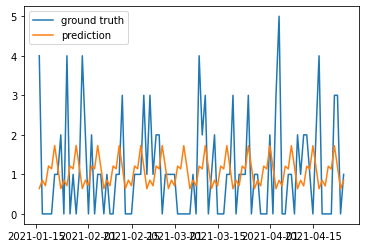

In [60]:
import seaborn as sns

def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

pred = predictions.values[0][1]
gt = total_df.loc[total_df['unique_id'] == predictions.values[0][0]].values[0, 1:-4][-TIME_HORIZON:]

sns.lineplot(x=time_index[-TIME_HORIZON:], y=gt, label='ground truth')
sns.lineplot(x=time_index[-TIME_HORIZON:], y=pred, label='prediction')

print("SMAPE: ", smape(gt, pred))

In [61]:
predictions.values[1]

('HOBBIES_1_001',
 array([4.98941909, 4.62836481, 5.85654328, 5.78425673, 5.42296488,
        9.09657317, 6.73094068, 5.04590334, 4.68484906, 5.91302752,
        5.84074098, 5.47944913, 9.15305741, 6.78742492, 5.10238758,
        4.7413333 , 5.96951177, 5.89722522, 5.53593337, 9.20954166,
        6.84390917, 5.15887183, 4.79781755, 6.02599601, 5.95370947,
        5.59241762, 9.2660259 , 6.90039341, 5.21535607, 4.85430179,
        6.08248026, 6.01019371, 5.64890186, 9.32251015, 6.95687766,
        5.27184032, 4.91078604, 6.1389645 , 6.06667796, 5.70538611,
        9.37899439, 7.0133619 , 5.32832456, 4.96727028, 6.19544875,
        6.1231622 , 5.76187035, 9.43547864, 7.06984615, 5.38480881,
        5.02375453, 6.25193299, 6.17964645, 5.8183546 , 9.49196289,
        7.12633039, 5.44129305, 5.08023877, 6.30841724, 6.2361307 ,
        5.87483884, 9.54844713, 7.18281464, 5.4977773 , 5.13672302,
        6.36490148, 6.29261494, 5.93132309, 9.60493138, 7.23929888,
        5.55426154, 5.19320726

### Export LHTS format

In [62]:
pickle.dump(time_index, open(data_dir + "m5_time_index_all.pkl", "wb"))

In [65]:
#parent_list

In [64]:
total_ts = total_bottom + total_parent

pred_tensor = np.zeros((total_ts, TIME_HORIZON))
gt_tensor = np.zeros((total_ts, TIME_HORIZON))

for i, ro in tqdm(total_df.iterrows()):
    gt_tensor[node_map_inv[ro.unique_id], :] = ro.values[1:-4][-TIME_HORIZON:]
    
for unique_id, pred in tqdm(predictions):
    pred_tensor[node_map_inv[unique_id], :] = pred

6218it [00:00, 10076.53it/s]
100%|████████████████████████████████████████████████████████| 6218/6218 [00:00<00:00, 463870.34it/s]


In [66]:
top_down_tensor = np.zeros((total_ts, TIME_HORIZON))
for l in tqdm(parent_list):
    i = l[0]
    for c in [l[3], l[2], l[1]]:
        if c != -1: break
    top_down_tensor[i, :] = gt_tensor[i, :] / (gt_tensor[c, :] + 1e-9)

100%|████████████████████████████████████████████████████████| 6218/6218 [00:00<00:00, 137774.61it/s]


In [67]:
level_2_tensor = np.zeros((total_ts, TIME_HORIZON))

for l in tqdm(parent_list):
    nz = list(filter(lambda x: x!=-1, l))
    if len(nz) == 1: continue
    i = l[0]
    c = l[-2]
    level_2_tensor[i, :] = gt_tensor[i, :] / (gt_tensor[c, :] + 1e-9)
    
level_3_tensor = np.zeros((total_ts, TIME_HORIZON))

for l in tqdm(parent_list):
    nz = list(filter(lambda x: x!=-1, l))
    if len(nz) <= 2: continue
    i = l[0]
    c = l[-3]
    level_3_tensor[i, :] = gt_tensor[i, :] / (gt_tensor[c, :] + 1e-9)

100%|████████████████████████████████████████████████████████| 6218/6218 [00:00<00:00, 156048.22it/s]


In [68]:
np.save(open(data_dir + 'm5_prediction_raw/pred_tensor.npy', 'wb'), pred_tensor)
np.save(open(data_dir + 'm5_prediction_raw/gt_tensor.npy', 'wb'), gt_tensor)
np.save(open(data_dir + 'm5_prediction_raw/top_down_tensor.npy', 'wb'), top_down_tensor)
np.save(open(data_dir + 'm5_prediction_raw/level_2_tensor.npy', 'wb'), level_2_tensor)
np.save(open(data_dir + 'm5_prediction_raw/level_3_tensor.npy', 'wb'), level_3_tensor)

### Export Nixtla format

In [69]:
pickle.dump(tags, open('m5_prediction_raw/tags.pkl', 'wb'))

In [70]:
y_gt = {'unique_id': [], 'ds': [], 'y': []}
y_hat = {'unique_id': [], 'ds': [], 'y': []}

idx = time_index[-TIME_HORIZON:]

for _, ro in tqdm(total_df.iterrows()):
    vals = ro[time_index].values.astype(np.int64)[-TIME_HORIZON:]
    for i in range(TIME_HORIZON):
        y_gt['unique_id'].append(ro.unique_id)
        y_gt['ds'].append(idx[i])
        y_gt['y'].append(vals[i])
        
for unique_id, pred in tqdm(predictions):
    for i in range(TIME_HORIZON):
        y_hat['unique_id'].append(unique_id)
        y_hat['ds'].append(idx[i])
        y_hat['y'].append(pred[i])

6218it [00:18, 338.80it/s]
100%|██████████████████████████████████████████████████████████| 6218/6218 [00:00<00:00, 9493.58it/s]


In [71]:
Y_gt = pd.DataFrame(y_gt)
Y_hat = pd.DataFrame(y_hat)
Y_hat.rename(columns = {'y': 'prophet'}, inplace=True)

Y_gt.to_csv(data_dir + 'm5_prediction_raw/nixtla_y_gt.csv', index=False)
Y_hat.to_csv(data_dir + 'm5_prediction_raw/nixtla_y_hat.csv', index=False)

In [72]:
import gc
nrow = len(tags['Cat']) + len(tags['Cat/Dept']) + len(tags['Cat/Dept/Item']) + len(tags['Cat/Dept/Item/State'])
ncol = len(tags['Cat/Dept/Item/State'])

columns = list(tags['Cat/Dept/Item/State'])
rows = list(tags['Cat']) + list(tags['Cat/Dept']) + list(tags['Cat/Dept/Item']) + list(tags['Cat/Dept/Item/State'])

In [73]:
raw_S = np.zeros((nrow, ncol))

In [74]:
rows_map = {v:k for k,v in dict(enumerate(rows)).items()}
columns_map = {v:k for k,v in dict(enumerate(columns)).items()}

In [75]:
for i, ro in tqdm(total_df.iterrows(), total=len(total_df)):
    if ro.unique_id not in columns_map: continue
    co = columns_map[ro.unique_id]
    ro4 = ro['Cat/Dept/Item/State']
    ro3 = ro['Cat/Dept/Item']
    ro2 = ro['Cat/Dept']
    ro1 = ro['Cat']
    if type(ro4) is str:
        raw_S[rows_map[ro4], co] = 1
    if type(ro3) is str:
        raw_S[rows_map[ro3], co] = 1
    if type(ro2) is str:
        raw_S[rows_map[ro2], co] = 1
    if type(ro1) is str:
        raw_S[rows_map[ro1], co] = 1

100%|██████████████████████████████████████████████████████████| 6218/6218 [00:00<00:00, 8513.35it/s]


In [76]:
raw_S.shape, pred_tensor.shape

((6218, 5650), (6218, 100))

In [77]:
np.save(open(data_dir + 'm5_prediction_raw/S_tensor.npy', 'wb'), raw_S)

In [78]:
S_df = pd.DataFrame(data=raw_S, dtype=np.int8)
S_df.columns = columns
S_df.index = rows

In [79]:
pickle.dump(S_df, open('m5_prediction_raw/nixtla_s.pkl', 'wb'))

In [80]:
S_df

,HOBBIES_1_001_CA_1,HOBBIES_1_002_CA_1,HOBBIES_1_003_CA_1,HOBBIES_1_004_CA_1,HOBBIES_1_005_CA_1,HOBBIES_1_006_CA_1,HOBBIES_1_007_CA_1,HOBBIES_1_008_CA_1,HOBBIES_1_009_CA_1,HOBBIES_1_010_CA_1,...,HOBBIES_2_140_WI_3,HOBBIES_2_141_WI_3,HOBBIES_2_142_WI_3,HOBBIES_2_143_WI_3,HOBBIES_2_144_WI_3,HOBBIES_2_145_WI_3,HOBBIES_2_146_WI_3,HOBBIES_2_147_WI_3,HOBBIES_2_148_WI_3,HOBBIES_2_149_WI_3
HOBBIES,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
HOBBIES_1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
HOBBIES_2,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
HOBBIES_1_001,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HOBBIES_1_002,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HOBBIES_2_145_WI_3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
HOBBIES_2_146_WI_3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
HOBBIES_2_147_WI_3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
HOBBIES_2_148_WI_3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
